In [1]:
import os

import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)

In [2]:
import keras
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Optimizer
from keras import callbacks
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional,concatenate
from keras.models import Model
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from keras.optimizers import Adam
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

np.random.seed(17)


import sys
import csv
from sklearn.ensemble import GradientBoostingClassifier
from feature_engineering import refuting_features, polarity_features, hand_features, gen_or_load_feats
from feature_engineering import word_overlap_features
from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split, get_stances_for_folds
from utils.score import report_score, LABELS, score_submission
from csv import DictReader
from csv import DictWriter
import codecs

from utils.system import parse_params, check_version

Using TensorFlow backend.


# Load data

In [3]:
train_bodies = pd.read_csv('./fnc-1/train_bodies.csv')
    
train_stances = pd.read_csv('./fnc-1/train_stances.csv')

test_bodies = pd.read_csv('./fnc-1/competition_test_bodies.csv')

test_stances = pd.read_csv('./fnc-1/competition_test_stances.csv')

# Merge and concate

In [4]:
train_stances['Stance'].replace('agree',0,True)
train_stances['Stance'].replace('disagree',1,True)
train_stances['Stance'].replace('discuss',2,True)
train_stances['Stance'].replace('unrelated',3,True)
train_merge = pd.merge(train_stances, train_bodies, on='Body ID')


test_stances['Stance'].replace('agree',0,True)
test_stances['Stance'].replace('disagree',1,True)
test_stances['Stance'].replace('discuss',2,True)
test_stances['Stance'].replace('unrelated',3,True)
test_merge = pd.merge(test_stances, test_bodies, on='Body ID')

test_merge.head(10)

,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,3,A RESPECTED senior French police officer inves...
1,Apple Stores to install safes to secure gold A...,2008,3,A RESPECTED senior French police officer inves...
2,Pregnant woman loses eye after police shoot be...,2008,3,A RESPECTED senior French police officer inves...
3,We just found out the #Ferguson Protester who ...,2008,3,A RESPECTED senior French police officer inves...
4,Police Chief In Charge of Paris Attacks Commit...,2008,2,A RESPECTED senior French police officer inves...
5,Ferguson protester shot in the eye with rubber...,2008,3,A RESPECTED senior French police officer inves...
6,Pregnant Ferguson woman loses her EYE after po...,2008,3,A RESPECTED senior French police officer inves...
7,Pregnant woman loses eye after Ferguson cops f...,2008,3,A RESPECTED senior French police officer inves...
8,Police officer in Charlie Hebdo investigation ...,2008,2,A RESPECTED senior French police officer inves...
9,Pregnant Woman Loses Eye During Ferguson Riots...,2008,3,A RESPECTED senior French police officer inves...


In [5]:
MAX_SENT_LEN = 16
MAX_VOCAB_SIZE = 50000
LSTM_DIM = 100
EMBEDDING_DIM = 50
BATCH_SIZE = 128
N_EPOCHS = 1
MAX_SENT_LEN1 = 100
MAX_VOCAB_SIZE1 = 50000


train_merge['Headline'].head(10)

test_merge['Headline'] = test_merge['Headline'].apply(lambda x: str(x))
train_merge['Headline'] = train_merge['Headline'].apply(lambda x: str(x))

test_merge['articleBody'] = test_merge['articleBody'].apply(lambda x: str(x))
train_merge['articleBody'] = train_merge['articleBody'].apply(lambda x: str(x))


train_merge = train_merge.sample(frac=1, random_state=10)


word_seq_train_stances = [text_to_word_sequence(head) for head in train_merge['Headline']]
word_seq_train_bodies = [text_to_word_sequence(body) for body in train_merge['articleBody']]



word_seq_test_stances = [text_to_word_sequence(head) for head in test_merge['Headline']]
word_seq_test_bodies = [text_to_word_sequence(body) for body in test_merge['articleBody']]

# Create a list for embedding

In [6]:
word_seq = []

for i in range(len(word_seq_train_stances)):
    word_seq.append(word_seq_train_stances[i])
for i in range(len(word_seq_train_bodies)):
    word_seq.append(word_seq_train_bodies[i])


for i in range(len(word_seq_test_stances)):
    word_seq.append(word_seq_test_stances[i])
for i in range(len(word_seq_test_bodies)):
    word_seq.append(word_seq_test_bodies[i])

In [7]:
word_seq_train_bodies[:10]

[['a',
  'desperate',
  'mother',
  'was',
  'tricked',
  'into',
  'feasting',
  'on',
  'cooked',
  'meat',
  'from',
  'the',
  'body',
  'of',
  'her',
  'son',
  'by',
  'islamic',
  'state',
  'militants',
  'it',
  'has',
  'been',
  'claimed',
  '\r',
  '\r',
  'the',
  'famished',
  'kurdish',
  'mother',
  'had',
  'gone',
  'to',
  'plead',
  'with',
  'the',
  'jihadists',
  'to',
  'release',
  'her',
  'son',
  '\r',
  '\r',
  'cruel',
  'militants',
  'delayed',
  'talks',
  'with',
  'the',
  'elderly',
  'mum',
  '–',
  'feeding',
  'her',
  'a',
  'meal',
  'made',
  'with',
  'the',
  'corpse',
  'of',
  'her',
  'offspring',
  'while',
  'she',
  'waited',
  '\r',
  '\r',
  'the',
  'depraved',
  'story',
  'was',
  'relayed',
  'by',
  'a',
  'brave',
  'briton',
  'fighting',
  'on',
  'the',
  'front',
  'line',
  'with',
  'kurdish',
  'forces',
  'against',
  'the',
  'islamic',
  'state',
  'also',
  'referred',
  'to',
  'as',
  'is',
  'isis',
  'and',
  'is

In [8]:

print('75th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq_train_stances], 75))
print('75th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq_train_bodies], 75))


75th Percentile Sentence Length: 13.0
75th Percentile Sentence Length: 500.0


# Pass the words through tokenizer

In [9]:
filter_list = '\r\t\n'
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])
print("Number of words in vocabulary:", len(tokenizer.word_index))

tokenizer.word_index

X = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_train_stances])
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')


Number of words in vocabulary: 37466


In [10]:
X1 = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN1]) for seq in word_seq_train_bodies])
X1 = pad_sequences(X1, maxlen=MAX_SENT_LEN1, padding='post', truncating='post')

In [11]:
X_test_bodies = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN1]) for seq in word_seq_test_bodies])
X_test_bodies = pad_sequences(X_test_bodies, maxlen=MAX_SENT_LEN1, padding='post', truncating='post')

In [12]:
X_test_bodies[:3]

array([[   4, 4681,  536, 1115,   91,  328, 1265,    1, 1495, 2137,  905,
        2331,  182,   19,  270,  166, 7201,  537,   37,    1, 2957,  504,
        2908,    1,  183, 1698, 3225, 2090, 2102,  601,    4, 1157,   11,
         441,    6,   19,   91,  291,    6, 3267,   83,  314,  296,   97,
        1490,  501,    4, 2935,  168,   19,  395,   24, 8827,   11,  466,
           1,  162,   37,  132, 2177,  498,   24,    1, 2027, 5742,  291,
           7,  195,  331,   65,  269,  831,    3,  137,  790, 1448, 1412,
         312,    1, 1923,    5, 5104,    5,    1,  255,   91,  205,  164,
        2090,   32,  197,   19,  270,  166,    0,    0,    0,    0,    0,
           0],
       [   4, 4681,  536, 1115,   91,  328, 1265,    1, 1495, 2137,  905,
        2331,  182,   19,  270,  166, 7201,  537,   37,    1, 2957,  504,
        2908,    1,  183, 1698, 3225, 2090, 2102,  601,    4, 1157,   11,
         441,    6,   19,   91,  291,    6, 3267,   83,  314,  296,   97,
        1490,  501,    

In [13]:
X_test_stances = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_test_stances])
X_test_stances = pad_sequences(X_test_stances, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

# Split train test data

In [14]:
y = train_merge['Stance']

encoder_train = LabelEncoder()
encoder_train.fit(y)
encoded_train = encoder_train.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

y_test = test_merge['Stance']



train_size =math.ceil( X.shape[0] * 0.9)
train_size_end =math.ceil( X.shape[0] * 0.2)

X_train = X[0:train_size]
X1_train = X1[0:train_size]

X_val = X[train_size:]
X1_val = X1[train_size:]

y_train = dummy_y_train[0:train_size]
y_val = dummy_y_train[train_size:]

print(X_train.shape)
print(X1_train.shape)
print(y_train.shape)

print(X_val.shape)
print(X1_val.shape)
print(y_val.shape)

(44975, 16)
(44975, 100)
(44975, 4)
(4997, 16)
(4997, 100)
(4997, 4)


# import glove embedding

In [15]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

glove_input_file = 'd:/641/glove.twitter.27B.50d.txt'
word2vec_output_file = 'glove.500d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)



D:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\anaconda\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(1193514, 50)

In [17]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

In [18]:
from keras.models import Sequential

# Generate 2 models for headline and article body seperately

In [19]:
def create_model2():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], 
                          input_length=MAX_SENT_LEN,
                          trainable=False, name='word_embedding_layer', #False
                          mask_zero=True))

    model.add(Dense(50,  name='dense_layer'))

    model.add(Dense(25, name='output_layer1'))
    return model

In [20]:
def create_model3():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          input_length=MAX_SENT_LEN1,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer1', #False
                          mask_zero=True))
    model.add(Dense(50, name='dense_layer1'))
    model.add(Dense(25,  name='output_layer2'))
    return model

# Concate the output then pass through a BiLSTM layer, dropout layer and dense layer

In [21]:
model_stance1 = create_model2()
model_bodies1 = create_model3()

combinedInput =keras.layers.Concatenate(axis=1)([model_stance1.output, model_bodies1.output])

x = Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm1'))(combinedInput)
x = Dropout(rate=0.2, name='dropout_2')(x)
x = Dense(4, activation="softmax")(x)
model = Model(inputs=[model_stance1.input, model_bodies1.input], outputs=x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'] )

filepath="divide_then_merge_textsummarization_{epoch:02d}_{val_loss:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_loss', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_embedding_layer_input (Inp (None, 16)           0                                            
__________________________________________________________________________________________________
word_embedding_layer1_input (In (None, 100)          0                                            
__________________________________________________________________________________________________
word_embedding_layer (Embedding (None, 16, 50)       1873350     word_embedding_layer_input[0][0] 
__________________________________________________________________________________________________
word_embedding_layer1 (Embeddin (None, 100, 50)      1873350     word_embedding_layer1_input[0][0]
__________________________________________________________________________________________________
dense_laye

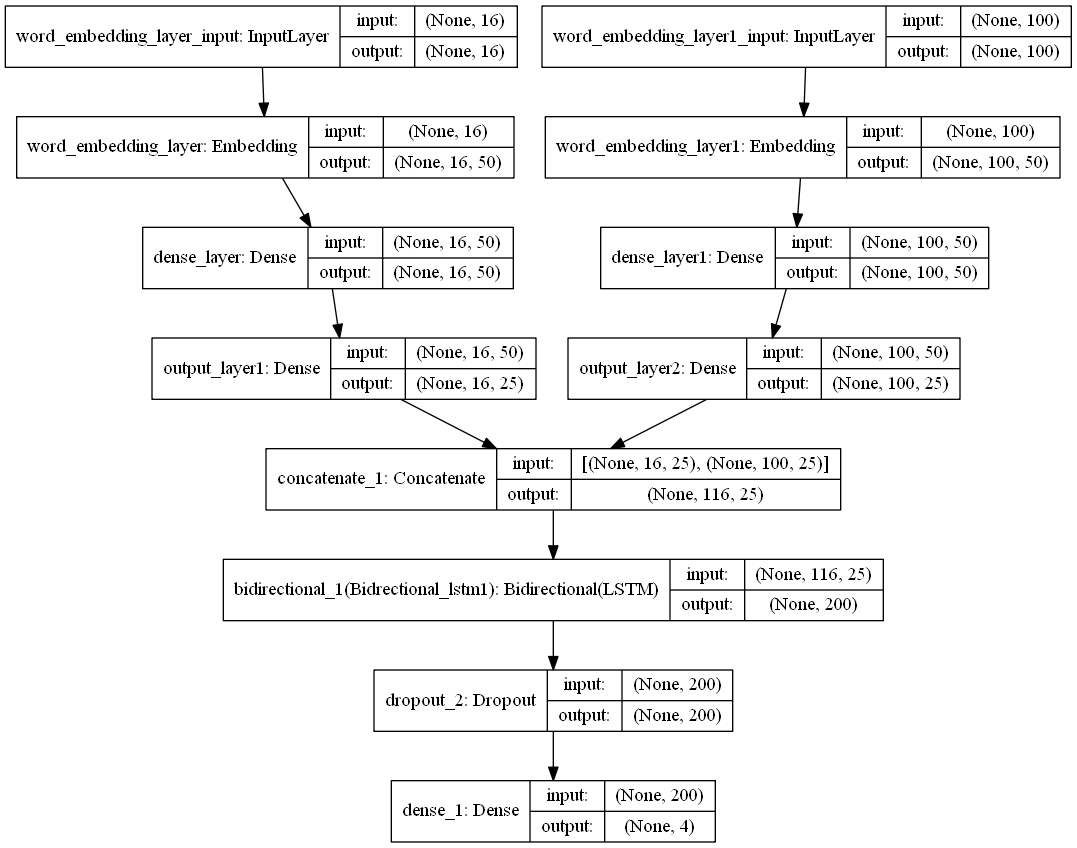

In [24]:
plot_model(model, to_file='bilstm_concate_model.png', show_layer_names=True, show_shapes=True)
Image('bilstm_concate_model.png')

# Train model

In [25]:
history  = model.fit(
    [X_train, X1_train], y_train,
    validation_data=([X_val, X1_val], y_val),
    epochs= 40, batch_size=BATCH_SIZE ,verbose = 1,callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 44975 samples, validate on 4997 samples
Epoch 1/40


26240/44975 [================>.............] - ETA: 15:53 - loss: 1.5077 - acc: 0.12 - ETA: 9:04 - loss: 1.3713 - acc: 0.3711 - ETA: 6:42 - loss: 1.2691 - acc: 0.481 - ETA: 5:33 - loss: 1.2033 - acc: 0.527 - ETA: 4:50 - loss: 1.1244 - acc: 0.573 - ETA: 4:21 - loss: 1.0658 - acc: 0.608 - ETA: 4:00 - loss: 1.0243 - acc: 0.630 - ETA: 3:44 - loss: 0.9935 - acc: 0.646 - ETA: 3:32 - loss: 1.0047 - acc: 0.645 - ETA: 3:23 - loss: 0.9849 - acc: 0.657 - ETA: 3:15 - loss: 0.9701 - acc: 0.664 - ETA: 3:08 - loss: 0.9609 - acc: 0.667 - ETA: 3:02 - loss: 0.9504 - acc: 0.671 - ETA: 2:57 - loss: 0.9422 - acc: 0.674 - ETA: 2:52 - loss: 0.9352 - acc: 0.678 - ETA: 2:48 - loss: 0.9345 - acc: 0.679 - ETA: 2:45 - loss: 0.9231 - acc: 0.686 - ETA: 2:42 - loss: 0.9133 - acc: 0.691 - ETA: 2:39 - loss: 0.9069 - acc: 0.694 - ETA: 2:37 - loss: 0.9026 - acc: 0.694 - ETA: 2:34 - loss: 0.8949 - acc: 0.697 - ETA: 2:32 - loss: 0.8908 - acc: 0.698 - ETA: 2:30 - loss: 0.8834 - acc: 0.700 - ETA: 2:28 - loss: 0.8776 - acc: 

44975/44975 [==============================] - ETA: 54s - loss: 0.7814 - acc: 0.72 - ETA: 54s - loss: 0.7813 - acc: 0.72 - ETA: 53s - loss: 0.7805 - acc: 0.72 - ETA: 53s - loss: 0.7801 - acc: 0.72 - ETA: 53s - loss: 0.7805 - acc: 0.72 - ETA: 52s - loss: 0.7801 - acc: 0.72 - ETA: 52s - loss: 0.7802 - acc: 0.72 - ETA: 51s - loss: 0.7800 - acc: 0.72 - ETA: 51s - loss: 0.7802 - acc: 0.72 - ETA: 51s - loss: 0.7796 - acc: 0.72 - ETA: 50s - loss: 0.7795 - acc: 0.72 - ETA: 50s - loss: 0.7792 - acc: 0.72 - ETA: 49s - loss: 0.7790 - acc: 0.72 - ETA: 49s - loss: 0.7783 - acc: 0.72 - ETA: 49s - loss: 0.7777 - acc: 0.72 - ETA: 48s - loss: 0.7769 - acc: 0.72 - ETA: 48s - loss: 0.7768 - acc: 0.72 - ETA: 48s - loss: 0.7771 - acc: 0.72 - ETA: 47s - loss: 0.7776 - acc: 0.72 - ETA: 47s - loss: 0.7774 - acc: 0.72 - ETA: 46s - loss: 0.7771 - acc: 0.72 - ETA: 46s - loss: 0.7764 - acc: 0.72 - ETA: 46s - loss: 0.7764 - acc: 0.72 - ETA: 45s - loss: 0.7762 - acc: 0.72 - ETA: 45s - loss: 0.7761 - acc: 0.72 - ETA

26240/44975 [================>.............] - ETA: 2:18 - loss: 0.5970 - acc: 0.750 - ETA: 2:10 - loss: 0.5820 - acc: 0.761 - ETA: 2:07 - loss: 0.6148 - acc: 0.750 - ETA: 2:05 - loss: 0.6273 - acc: 0.738 - ETA: 2:05 - loss: 0.6186 - acc: 0.748 - ETA: 2:04 - loss: 0.6201 - acc: 0.748 - ETA: 2:03 - loss: 0.6239 - acc: 0.753 - ETA: 2:03 - loss: 0.6189 - acc: 0.756 - ETA: 2:02 - loss: 0.6026 - acc: 0.765 - ETA: 2:01 - loss: 0.6083 - acc: 0.758 - ETA: 2:00 - loss: 0.6107 - acc: 0.757 - ETA: 2:00 - loss: 0.6126 - acc: 0.757 - ETA: 2:00 - loss: 0.6065 - acc: 0.760 - ETA: 1:59 - loss: 0.6038 - acc: 0.760 - ETA: 1:58 - loss: 0.6034 - acc: 0.762 - ETA: 1:58 - loss: 0.5967 - acc: 0.764 - ETA: 1:57 - loss: 0.6065 - acc: 0.761 - ETA: 1:57 - loss: 0.6148 - acc: 0.759 - ETA: 1:57 - loss: 0.6160 - acc: 0.758 - ETA: 1:57 - loss: 0.6157 - acc: 0.760 - ETA: 1:56 - loss: 0.6177 - acc: 0.761 - ETA: 1:56 - loss: 0.6171 - acc: 0.762 - ETA: 1:56 - loss: 0.6200 - acc: 0.763 - ETA: 1:56 - loss: 0.6212 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.5981 - acc: 0.77 - ETA: 51s - loss: 0.5982 - acc: 0.77 - ETA: 51s - loss: 0.5977 - acc: 0.77 - ETA: 50s - loss: 0.5977 - acc: 0.77 - ETA: 50s - loss: 0.5976 - acc: 0.77 - ETA: 50s - loss: 0.5980 - acc: 0.77 - ETA: 49s - loss: 0.5977 - acc: 0.77 - ETA: 49s - loss: 0.5972 - acc: 0.77 - ETA: 49s - loss: 0.5970 - acc: 0.77 - ETA: 48s - loss: 0.5971 - acc: 0.77 - ETA: 48s - loss: 0.5967 - acc: 0.77 - ETA: 48s - loss: 0.5966 - acc: 0.77 - ETA: 47s - loss: 0.5964 - acc: 0.77 - ETA: 47s - loss: 0.5964 - acc: 0.77 - ETA: 46s - loss: 0.5964 - acc: 0.77 - ETA: 46s - loss: 0.5964 - acc: 0.77 - ETA: 46s - loss: 0.5961 - acc: 0.77 - ETA: 45s - loss: 0.5960 - acc: 0.77 - ETA: 45s - loss: 0.5961 - acc: 0.77 - ETA: 45s - loss: 0.5954 - acc: 0.77 - ETA: 44s - loss: 0.5951 - acc: 0.77 - ETA: 44s - loss: 0.5954 - acc: 0.77 - ETA: 44s - loss: 0.5952 - acc: 0.77 - ETA: 43s - loss: 0.5949 - acc: 0.77 - ETA: 43s - loss: 0.5950 - acc: 0.77 - ETA

26240/44975 [================>.............] - ETA: 2:09 - loss: 0.5006 - acc: 0.820 - ETA: 2:08 - loss: 0.5174 - acc: 0.785 - ETA: 2:09 - loss: 0.5478 - acc: 0.789 - ETA: 2:09 - loss: 0.5281 - acc: 0.804 - ETA: 2:09 - loss: 0.5109 - acc: 0.814 - ETA: 2:08 - loss: 0.5057 - acc: 0.815 - ETA: 2:09 - loss: 0.5002 - acc: 0.817 - ETA: 2:08 - loss: 0.5010 - acc: 0.815 - ETA: 2:07 - loss: 0.4923 - acc: 0.818 - ETA: 2:07 - loss: 0.4946 - acc: 0.818 - ETA: 2:06 - loss: 0.4942 - acc: 0.814 - ETA: 2:05 - loss: 0.5009 - acc: 0.811 - ETA: 2:04 - loss: 0.5037 - acc: 0.809 - ETA: 2:03 - loss: 0.5119 - acc: 0.807 - ETA: 2:03 - loss: 0.5089 - acc: 0.807 - ETA: 2:02 - loss: 0.5135 - acc: 0.804 - ETA: 2:02 - loss: 0.5196 - acc: 0.802 - ETA: 2:01 - loss: 0.5176 - acc: 0.804 - ETA: 2:00 - loss: 0.5122 - acc: 0.806 - ETA: 2:00 - loss: 0.5177 - acc: 0.805 - ETA: 1:59 - loss: 0.5139 - acc: 0.806 - ETA: 1:59 - loss: 0.5093 - acc: 0.807 - ETA: 1:58 - loss: 0.5086 - acc: 0.807 - ETA: 1:58 - loss: 0.5150 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.4819 - acc: 0.81 - ETA: 52s - loss: 0.4820 - acc: 0.81 - ETA: 51s - loss: 0.4820 - acc: 0.81 - ETA: 51s - loss: 0.4816 - acc: 0.81 - ETA: 51s - loss: 0.4815 - acc: 0.81 - ETA: 50s - loss: 0.4810 - acc: 0.81 - ETA: 50s - loss: 0.4806 - acc: 0.81 - ETA: 50s - loss: 0.4806 - acc: 0.81 - ETA: 49s - loss: 0.4807 - acc: 0.81 - ETA: 49s - loss: 0.4806 - acc: 0.81 - ETA: 48s - loss: 0.4801 - acc: 0.81 - ETA: 48s - loss: 0.4803 - acc: 0.81 - ETA: 48s - loss: 0.4801 - acc: 0.81 - ETA: 47s - loss: 0.4803 - acc: 0.81 - ETA: 47s - loss: 0.4800 - acc: 0.81 - ETA: 47s - loss: 0.4795 - acc: 0.81 - ETA: 46s - loss: 0.4798 - acc: 0.81 - ETA: 46s - loss: 0.4801 - acc: 0.81 - ETA: 46s - loss: 0.4800 - acc: 0.81 - ETA: 45s - loss: 0.4793 - acc: 0.81 - ETA: 45s - loss: 0.4795 - acc: 0.81 - ETA: 44s - loss: 0.4792 - acc: 0.81 - ETA: 44s - loss: 0.4795 - acc: 0.81 - ETA: 44s - loss: 0.4796 - acc: 0.81 - ETA: 43s - loss: 0.4790 - acc: 0.81 - ETA

26240/44975 [================>.............] - ETA: 2:03 - loss: 0.4272 - acc: 0.843 - ETA: 2:04 - loss: 0.4007 - acc: 0.839 - ETA: 2:06 - loss: 0.3884 - acc: 0.849 - ETA: 2:05 - loss: 0.3918 - acc: 0.845 - ETA: 2:07 - loss: 0.3904 - acc: 0.845 - ETA: 2:06 - loss: 0.3883 - acc: 0.846 - ETA: 2:06 - loss: 0.3885 - acc: 0.846 - ETA: 2:05 - loss: 0.3939 - acc: 0.842 - ETA: 2:05 - loss: 0.3938 - acc: 0.840 - ETA: 2:05 - loss: 0.3955 - acc: 0.842 - ETA: 2:04 - loss: 0.3906 - acc: 0.841 - ETA: 2:03 - loss: 0.3829 - acc: 0.844 - ETA: 2:03 - loss: 0.3821 - acc: 0.845 - ETA: 2:02 - loss: 0.3807 - acc: 0.848 - ETA: 2:01 - loss: 0.3866 - acc: 0.846 - ETA: 2:01 - loss: 0.3810 - acc: 0.849 - ETA: 2:00 - loss: 0.3811 - acc: 0.850 - ETA: 1:59 - loss: 0.3892 - acc: 0.848 - ETA: 1:59 - loss: 0.3885 - acc: 0.849 - ETA: 1:59 - loss: 0.3853 - acc: 0.850 - ETA: 1:58 - loss: 0.3786 - acc: 0.853 - ETA: 1:58 - loss: 0.3759 - acc: 0.853 - ETA: 1:58 - loss: 0.3751 - acc: 0.853 - ETA: 1:57 - loss: 0.3736 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.3837 - acc: 0.85 - ETA: 52s - loss: 0.3829 - acc: 0.85 - ETA: 51s - loss: 0.3832 - acc: 0.85 - ETA: 51s - loss: 0.3831 - acc: 0.85 - ETA: 50s - loss: 0.3832 - acc: 0.85 - ETA: 50s - loss: 0.3831 - acc: 0.85 - ETA: 50s - loss: 0.3828 - acc: 0.85 - ETA: 49s - loss: 0.3821 - acc: 0.85 - ETA: 49s - loss: 0.3822 - acc: 0.85 - ETA: 49s - loss: 0.3819 - acc: 0.85 - ETA: 48s - loss: 0.3819 - acc: 0.85 - ETA: 48s - loss: 0.3816 - acc: 0.85 - ETA: 48s - loss: 0.3814 - acc: 0.85 - ETA: 47s - loss: 0.3816 - acc: 0.85 - ETA: 47s - loss: 0.3816 - acc: 0.85 - ETA: 47s - loss: 0.3818 - acc: 0.85 - ETA: 46s - loss: 0.3821 - acc: 0.85 - ETA: 46s - loss: 0.3827 - acc: 0.85 - ETA: 46s - loss: 0.3829 - acc: 0.85 - ETA: 45s - loss: 0.3826 - acc: 0.85 - ETA: 45s - loss: 0.3821 - acc: 0.85 - ETA: 44s - loss: 0.3819 - acc: 0.85 - ETA: 44s - loss: 0.3818 - acc: 0.85 - ETA: 44s - loss: 0.3813 - acc: 0.85 - ETA: 43s - loss: 0.3812 - acc: 0.85 - ETA

26240/44975 [================>.............] - ETA: 2:25 - loss: 0.2874 - acc: 0.867 - ETA: 2:21 - loss: 0.3029 - acc: 0.871 - ETA: 2:20 - loss: 0.3090 - acc: 0.880 - ETA: 2:16 - loss: 0.3168 - acc: 0.875 - ETA: 2:14 - loss: 0.2971 - acc: 0.887 - ETA: 2:14 - loss: 0.2962 - acc: 0.886 - ETA: 2:13 - loss: 0.2926 - acc: 0.889 - ETA: 2:15 - loss: 0.2899 - acc: 0.889 - ETA: 2:15 - loss: 0.3037 - acc: 0.886 - ETA: 2:14 - loss: 0.3068 - acc: 0.883 - ETA: 2:14 - loss: 0.3071 - acc: 0.884 - ETA: 2:13 - loss: 0.3093 - acc: 0.882 - ETA: 2:13 - loss: 0.3193 - acc: 0.879 - ETA: 2:13 - loss: 0.3239 - acc: 0.877 - ETA: 2:12 - loss: 0.3251 - acc: 0.876 - ETA: 2:11 - loss: 0.3162 - acc: 0.879 - ETA: 2:10 - loss: 0.3149 - acc: 0.880 - ETA: 2:09 - loss: 0.3107 - acc: 0.881 - ETA: 2:08 - loss: 0.3106 - acc: 0.881 - ETA: 2:08 - loss: 0.3133 - acc: 0.881 - ETA: 2:08 - loss: 0.3176 - acc: 0.880 - ETA: 2:07 - loss: 0.3170 - acc: 0.880 - ETA: 2:07 - loss: 0.3220 - acc: 0.877 - ETA: 2:06 - loss: 0.3251 - acc: 0

44975/44975 [==============================] - ETA: 53s - loss: 0.3136 - acc: 0.88 - ETA: 52s - loss: 0.3137 - acc: 0.88 - ETA: 52s - loss: 0.3144 - acc: 0.88 - ETA: 51s - loss: 0.3141 - acc: 0.88 - ETA: 51s - loss: 0.3143 - acc: 0.88 - ETA: 51s - loss: 0.3142 - acc: 0.88 - ETA: 50s - loss: 0.3141 - acc: 0.88 - ETA: 50s - loss: 0.3139 - acc: 0.88 - ETA: 50s - loss: 0.3133 - acc: 0.88 - ETA: 49s - loss: 0.3130 - acc: 0.88 - ETA: 49s - loss: 0.3132 - acc: 0.88 - ETA: 49s - loss: 0.3134 - acc: 0.88 - ETA: 48s - loss: 0.3131 - acc: 0.88 - ETA: 48s - loss: 0.3131 - acc: 0.88 - ETA: 47s - loss: 0.3126 - acc: 0.88 - ETA: 47s - loss: 0.3123 - acc: 0.88 - ETA: 47s - loss: 0.3125 - acc: 0.88 - ETA: 46s - loss: 0.3121 - acc: 0.88 - ETA: 46s - loss: 0.3122 - acc: 0.88 - ETA: 46s - loss: 0.3117 - acc: 0.88 - ETA: 45s - loss: 0.3111 - acc: 0.88 - ETA: 45s - loss: 0.3112 - acc: 0.88 - ETA: 44s - loss: 0.3111 - acc: 0.88 - ETA: 44s - loss: 0.3112 - acc: 0.88 - ETA: 44s - loss: 0.3116 - acc: 0.88 - ETA

26240/44975 [================>.............] - ETA: 1:58 - loss: 0.2476 - acc: 0.906 - ETA: 2:01 - loss: 0.2413 - acc: 0.918 - ETA: 2:03 - loss: 0.2517 - acc: 0.919 - ETA: 2:02 - loss: 0.2647 - acc: 0.912 - ETA: 2:01 - loss: 0.2493 - acc: 0.918 - ETA: 2:00 - loss: 0.2514 - acc: 0.918 - ETA: 2:00 - loss: 0.2533 - acc: 0.912 - ETA: 2:00 - loss: 0.2523 - acc: 0.910 - ETA: 1:59 - loss: 0.2535 - acc: 0.910 - ETA: 1:59 - loss: 0.2479 - acc: 0.912 - ETA: 1:59 - loss: 0.2425 - acc: 0.912 - ETA: 1:59 - loss: 0.2439 - acc: 0.914 - ETA: 1:58 - loss: 0.2427 - acc: 0.913 - ETA: 1:58 - loss: 0.2424 - acc: 0.911 - ETA: 1:58 - loss: 0.2403 - acc: 0.912 - ETA: 1:57 - loss: 0.2368 - acc: 0.914 - ETA: 1:57 - loss: 0.2413 - acc: 0.911 - ETA: 1:57 - loss: 0.2515 - acc: 0.906 - ETA: 1:57 - loss: 0.2512 - acc: 0.906 - ETA: 1:56 - loss: 0.2472 - acc: 0.907 - ETA: 1:56 - loss: 0.2498 - acc: 0.906 - ETA: 1:56 - loss: 0.2511 - acc: 0.905 - ETA: 1:55 - loss: 0.2490 - acc: 0.906 - ETA: 1:55 - loss: 0.2474 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.2517 - acc: 0.90 - ETA: 51s - loss: 0.2518 - acc: 0.90 - ETA: 50s - loss: 0.2521 - acc: 0.90 - ETA: 50s - loss: 0.2521 - acc: 0.90 - ETA: 50s - loss: 0.2520 - acc: 0.90 - ETA: 49s - loss: 0.2525 - acc: 0.90 - ETA: 49s - loss: 0.2528 - acc: 0.90 - ETA: 49s - loss: 0.2527 - acc: 0.90 - ETA: 48s - loss: 0.2527 - acc: 0.90 - ETA: 48s - loss: 0.2524 - acc: 0.90 - ETA: 48s - loss: 0.2526 - acc: 0.90 - ETA: 47s - loss: 0.2527 - acc: 0.90 - ETA: 47s - loss: 0.2526 - acc: 0.90 - ETA: 47s - loss: 0.2525 - acc: 0.90 - ETA: 46s - loss: 0.2523 - acc: 0.90 - ETA: 46s - loss: 0.2524 - acc: 0.90 - ETA: 45s - loss: 0.2523 - acc: 0.90 - ETA: 45s - loss: 0.2520 - acc: 0.90 - ETA: 45s - loss: 0.2520 - acc: 0.90 - ETA: 44s - loss: 0.2519 - acc: 0.90 - ETA: 44s - loss: 0.2519 - acc: 0.90 - ETA: 44s - loss: 0.2519 - acc: 0.90 - ETA: 43s - loss: 0.2515 - acc: 0.90 - ETA: 43s - loss: 0.2521 - acc: 0.90 - ETA: 43s - loss: 0.2520 - acc: 0.90 - ETA

26240/44975 [================>.............] - ETA: 2:01 - loss: 0.2742 - acc: 0.937 - ETA: 2:03 - loss: 0.2981 - acc: 0.902 - ETA: 2:05 - loss: 0.2796 - acc: 0.903 - ETA: 2:03 - loss: 0.2676 - acc: 0.908 - ETA: 2:04 - loss: 0.2608 - acc: 0.912 - ETA: 2:03 - loss: 0.2552 - acc: 0.911 - ETA: 2:02 - loss: 0.2505 - acc: 0.914 - ETA: 2:02 - loss: 0.2402 - acc: 0.918 - ETA: 2:01 - loss: 0.2406 - acc: 0.919 - ETA: 2:01 - loss: 0.2334 - acc: 0.920 - ETA: 2:00 - loss: 0.2352 - acc: 0.919 - ETA: 2:00 - loss: 0.2430 - acc: 0.914 - ETA: 1:59 - loss: 0.2393 - acc: 0.914 - ETA: 1:59 - loss: 0.2367 - acc: 0.915 - ETA: 1:59 - loss: 0.2340 - acc: 0.915 - ETA: 1:58 - loss: 0.2360 - acc: 0.916 - ETA: 1:58 - loss: 0.2385 - acc: 0.914 - ETA: 1:57 - loss: 0.2370 - acc: 0.914 - ETA: 1:57 - loss: 0.2339 - acc: 0.916 - ETA: 1:57 - loss: 0.2314 - acc: 0.918 - ETA: 1:56 - loss: 0.2291 - acc: 0.919 - ETA: 1:56 - loss: 0.2280 - acc: 0.919 - ETA: 1:55 - loss: 0.2287 - acc: 0.919 - ETA: 1:55 - loss: 0.2268 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.2096 - acc: 0.92 - ETA: 51s - loss: 0.2097 - acc: 0.92 - ETA: 50s - loss: 0.2100 - acc: 0.92 - ETA: 50s - loss: 0.2101 - acc: 0.92 - ETA: 50s - loss: 0.2097 - acc: 0.92 - ETA: 49s - loss: 0.2096 - acc: 0.92 - ETA: 49s - loss: 0.2096 - acc: 0.92 - ETA: 49s - loss: 0.2097 - acc: 0.92 - ETA: 48s - loss: 0.2105 - acc: 0.92 - ETA: 48s - loss: 0.2102 - acc: 0.92 - ETA: 48s - loss: 0.2104 - acc: 0.92 - ETA: 47s - loss: 0.2105 - acc: 0.92 - ETA: 47s - loss: 0.2107 - acc: 0.92 - ETA: 46s - loss: 0.2104 - acc: 0.92 - ETA: 46s - loss: 0.2105 - acc: 0.92 - ETA: 46s - loss: 0.2102 - acc: 0.92 - ETA: 45s - loss: 0.2101 - acc: 0.92 - ETA: 45s - loss: 0.2100 - acc: 0.92 - ETA: 45s - loss: 0.2103 - acc: 0.92 - ETA: 44s - loss: 0.2099 - acc: 0.92 - ETA: 44s - loss: 0.2100 - acc: 0.92 - ETA: 44s - loss: 0.2103 - acc: 0.92 - ETA: 43s - loss: 0.2101 - acc: 0.92 - ETA: 43s - loss: 0.2097 - acc: 0.92 - ETA: 43s - loss: 0.2097 - acc: 0.92 - ETA

26240/44975 [================>.............] - ETA: 2:03 - loss: 0.3050 - acc: 0.867 - ETA: 2:06 - loss: 0.2240 - acc: 0.906 - ETA: 2:07 - loss: 0.2268 - acc: 0.898 - ETA: 2:06 - loss: 0.2061 - acc: 0.908 - ETA: 2:06 - loss: 0.2124 - acc: 0.906 - ETA: 2:05 - loss: 0.2279 - acc: 0.907 - ETA: 2:04 - loss: 0.2159 - acc: 0.914 - ETA: 2:04 - loss: 0.2093 - acc: 0.916 - ETA: 2:03 - loss: 0.2003 - acc: 0.921 - ETA: 2:03 - loss: 0.2028 - acc: 0.921 - ETA: 2:02 - loss: 0.1979 - acc: 0.922 - ETA: 2:02 - loss: 0.2003 - acc: 0.921 - ETA: 2:01 - loss: 0.1985 - acc: 0.923 - ETA: 2:01 - loss: 0.1957 - acc: 0.925 - ETA: 2:01 - loss: 0.1936 - acc: 0.926 - ETA: 2:00 - loss: 0.1911 - acc: 0.927 - ETA: 2:00 - loss: 0.1952 - acc: 0.927 - ETA: 2:00 - loss: 0.1993 - acc: 0.925 - ETA: 2:00 - loss: 0.1980 - acc: 0.925 - ETA: 1:59 - loss: 0.1952 - acc: 0.927 - ETA: 1:59 - loss: 0.1936 - acc: 0.927 - ETA: 1:58 - loss: 0.1919 - acc: 0.928 - ETA: 1:58 - loss: 0.1962 - acc: 0.926 - ETA: 1:58 - loss: 0.1966 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.1822 - acc: 0.93 - ETA: 51s - loss: 0.1820 - acc: 0.93 - ETA: 51s - loss: 0.1816 - acc: 0.93 - ETA: 50s - loss: 0.1819 - acc: 0.93 - ETA: 50s - loss: 0.1820 - acc: 0.93 - ETA: 50s - loss: 0.1818 - acc: 0.93 - ETA: 49s - loss: 0.1815 - acc: 0.93 - ETA: 49s - loss: 0.1813 - acc: 0.93 - ETA: 49s - loss: 0.1811 - acc: 0.93 - ETA: 48s - loss: 0.1813 - acc: 0.93 - ETA: 48s - loss: 0.1813 - acc: 0.93 - ETA: 48s - loss: 0.1814 - acc: 0.93 - ETA: 47s - loss: 0.1814 - acc: 0.93 - ETA: 47s - loss: 0.1822 - acc: 0.93 - ETA: 47s - loss: 0.1820 - acc: 0.93 - ETA: 46s - loss: 0.1820 - acc: 0.93 - ETA: 46s - loss: 0.1820 - acc: 0.93 - ETA: 45s - loss: 0.1823 - acc: 0.93 - ETA: 45s - loss: 0.1822 - acc: 0.93 - ETA: 45s - loss: 0.1823 - acc: 0.93 - ETA: 44s - loss: 0.1821 - acc: 0.93 - ETA: 44s - loss: 0.1822 - acc: 0.93 - ETA: 44s - loss: 0.1823 - acc: 0.93 - ETA: 43s - loss: 0.1822 - acc: 0.93 - ETA: 43s - loss: 0.1826 - acc: 0.93 - ETA

26240/44975 [================>.............] - ETA: 1:59 - loss: 0.1346 - acc: 0.945 - ETA: 2:00 - loss: 0.1245 - acc: 0.960 - ETA: 2:01 - loss: 0.1043 - acc: 0.968 - ETA: 2:01 - loss: 0.1339 - acc: 0.957 - ETA: 2:01 - loss: 0.1422 - acc: 0.953 - ETA: 2:00 - loss: 0.1400 - acc: 0.950 - ETA: 2:00 - loss: 0.1488 - acc: 0.942 - ETA: 2:00 - loss: 0.1443 - acc: 0.944 - ETA: 1:59 - loss: 0.1466 - acc: 0.943 - ETA: 1:59 - loss: 0.1436 - acc: 0.946 - ETA: 1:59 - loss: 0.1432 - acc: 0.946 - ETA: 1:59 - loss: 0.1422 - acc: 0.948 - ETA: 1:59 - loss: 0.1425 - acc: 0.947 - ETA: 1:58 - loss: 0.1430 - acc: 0.948 - ETA: 1:58 - loss: 0.1462 - acc: 0.947 - ETA: 1:57 - loss: 0.1466 - acc: 0.947 - ETA: 1:57 - loss: 0.1468 - acc: 0.948 - ETA: 1:57 - loss: 0.1474 - acc: 0.947 - ETA: 1:56 - loss: 0.1508 - acc: 0.944 - ETA: 1:56 - loss: 0.1503 - acc: 0.944 - ETA: 1:56 - loss: 0.1481 - acc: 0.945 - ETA: 1:55 - loss: 0.1478 - acc: 0.946 - ETA: 1:55 - loss: 0.1486 - acc: 0.946 - ETA: 1:55 - loss: 0.1488 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.1643 - acc: 0.93 - ETA: 51s - loss: 0.1642 - acc: 0.93 - ETA: 50s - loss: 0.1643 - acc: 0.93 - ETA: 50s - loss: 0.1641 - acc: 0.93 - ETA: 49s - loss: 0.1639 - acc: 0.93 - ETA: 49s - loss: 0.1638 - acc: 0.93 - ETA: 49s - loss: 0.1638 - acc: 0.93 - ETA: 48s - loss: 0.1637 - acc: 0.93 - ETA: 48s - loss: 0.1636 - acc: 0.93 - ETA: 48s - loss: 0.1638 - acc: 0.93 - ETA: 47s - loss: 0.1640 - acc: 0.93 - ETA: 47s - loss: 0.1641 - acc: 0.93 - ETA: 47s - loss: 0.1645 - acc: 0.93 - ETA: 46s - loss: 0.1646 - acc: 0.93 - ETA: 46s - loss: 0.1645 - acc: 0.93 - ETA: 46s - loss: 0.1644 - acc: 0.93 - ETA: 45s - loss: 0.1647 - acc: 0.93 - ETA: 45s - loss: 0.1647 - acc: 0.93 - ETA: 45s - loss: 0.1645 - acc: 0.93 - ETA: 44s - loss: 0.1642 - acc: 0.93 - ETA: 44s - loss: 0.1641 - acc: 0.93 - ETA: 43s - loss: 0.1640 - acc: 0.93 - ETA: 43s - loss: 0.1638 - acc: 0.93 - ETA: 43s - loss: 0.1640 - acc: 0.93 - ETA: 42s - loss: 0.1641 - acc: 0.93 - ETA

26240/44975 [================>.............] - ETA: 2:18 - loss: 0.1780 - acc: 0.929 - ETA: 2:22 - loss: 0.1622 - acc: 0.937 - ETA: 2:21 - loss: 0.1311 - acc: 0.953 - ETA: 2:18 - loss: 0.1221 - acc: 0.953 - ETA: 2:16 - loss: 0.1207 - acc: 0.953 - ETA: 2:16 - loss: 0.1211 - acc: 0.957 - ETA: 2:14 - loss: 0.1300 - acc: 0.952 - ETA: 2:12 - loss: 0.1307 - acc: 0.952 - ETA: 2:10 - loss: 0.1281 - acc: 0.952 - ETA: 2:09 - loss: 0.1296 - acc: 0.952 - ETA: 2:08 - loss: 0.1301 - acc: 0.953 - ETA: 2:07 - loss: 0.1298 - acc: 0.952 - ETA: 2:06 - loss: 0.1302 - acc: 0.951 - ETA: 2:05 - loss: 0.1292 - acc: 0.952 - ETA: 2:05 - loss: 0.1246 - acc: 0.954 - ETA: 2:04 - loss: 0.1272 - acc: 0.954 - ETA: 2:03 - loss: 0.1296 - acc: 0.953 - ETA: 2:03 - loss: 0.1336 - acc: 0.951 - ETA: 2:02 - loss: 0.1314 - acc: 0.952 - ETA: 2:02 - loss: 0.1329 - acc: 0.952 - ETA: 2:01 - loss: 0.1332 - acc: 0.952 - ETA: 2:01 - loss: 0.1335 - acc: 0.953 - ETA: 2:00 - loss: 0.1360 - acc: 0.952 - ETA: 2:00 - loss: 0.1362 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.1366 - acc: 0.94 - ETA: 51s - loss: 0.1366 - acc: 0.94 - ETA: 51s - loss: 0.1366 - acc: 0.94 - ETA: 50s - loss: 0.1365 - acc: 0.94 - ETA: 50s - loss: 0.1364 - acc: 0.94 - ETA: 50s - loss: 0.1368 - acc: 0.94 - ETA: 49s - loss: 0.1368 - acc: 0.94 - ETA: 49s - loss: 0.1367 - acc: 0.94 - ETA: 49s - loss: 0.1370 - acc: 0.94 - ETA: 48s - loss: 0.1371 - acc: 0.94 - ETA: 48s - loss: 0.1370 - acc: 0.94 - ETA: 47s - loss: 0.1367 - acc: 0.94 - ETA: 47s - loss: 0.1369 - acc: 0.94 - ETA: 47s - loss: 0.1369 - acc: 0.94 - ETA: 46s - loss: 0.1368 - acc: 0.94 - ETA: 46s - loss: 0.1369 - acc: 0.94 - ETA: 46s - loss: 0.1369 - acc: 0.94 - ETA: 45s - loss: 0.1369 - acc: 0.94 - ETA: 45s - loss: 0.1369 - acc: 0.94 - ETA: 45s - loss: 0.1373 - acc: 0.94 - ETA: 44s - loss: 0.1373 - acc: 0.94 - ETA: 44s - loss: 0.1373 - acc: 0.94 - ETA: 43s - loss: 0.1376 - acc: 0.94 - ETA: 43s - loss: 0.1374 - acc: 0.94 - ETA: 43s - loss: 0.1371 - acc: 0.94 - ETA

26240/44975 [================>.............] - ETA: 2:02 - loss: 0.2060 - acc: 0.921 - ETA: 2:01 - loss: 0.1586 - acc: 0.937 - ETA: 2:03 - loss: 0.1634 - acc: 0.940 - ETA: 2:02 - loss: 0.1472 - acc: 0.945 - ETA: 2:01 - loss: 0.1522 - acc: 0.945 - ETA: 2:01 - loss: 0.1533 - acc: 0.946 - ETA: 2:01 - loss: 0.1494 - acc: 0.946 - ETA: 2:00 - loss: 0.1418 - acc: 0.948 - ETA: 2:00 - loss: 0.1354 - acc: 0.950 - ETA: 2:00 - loss: 0.1294 - acc: 0.953 - ETA: 2:00 - loss: 0.1342 - acc: 0.951 - ETA: 2:00 - loss: 0.1333 - acc: 0.951 - ETA: 1:59 - loss: 0.1297 - acc: 0.953 - ETA: 1:59 - loss: 0.1276 - acc: 0.954 - ETA: 1:58 - loss: 0.1232 - acc: 0.957 - ETA: 1:58 - loss: 0.1198 - acc: 0.958 - ETA: 1:58 - loss: 0.1230 - acc: 0.956 - ETA: 1:57 - loss: 0.1203 - acc: 0.957 - ETA: 1:57 - loss: 0.1202 - acc: 0.957 - ETA: 1:57 - loss: 0.1199 - acc: 0.956 - ETA: 1:56 - loss: 0.1188 - acc: 0.956 - ETA: 1:56 - loss: 0.1183 - acc: 0.956 - ETA: 1:55 - loss: 0.1189 - acc: 0.956 - ETA: 1:55 - loss: 0.1183 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.1255 - acc: 0.95 - ETA: 51s - loss: 0.1257 - acc: 0.95 - ETA: 50s - loss: 0.1255 - acc: 0.95 - ETA: 50s - loss: 0.1253 - acc: 0.95 - ETA: 50s - loss: 0.1252 - acc: 0.95 - ETA: 49s - loss: 0.1254 - acc: 0.95 - ETA: 49s - loss: 0.1253 - acc: 0.95 - ETA: 48s - loss: 0.1254 - acc: 0.95 - ETA: 48s - loss: 0.1257 - acc: 0.95 - ETA: 48s - loss: 0.1257 - acc: 0.95 - ETA: 47s - loss: 0.1256 - acc: 0.95 - ETA: 47s - loss: 0.1257 - acc: 0.95 - ETA: 47s - loss: 0.1256 - acc: 0.95 - ETA: 46s - loss: 0.1257 - acc: 0.95 - ETA: 46s - loss: 0.1254 - acc: 0.95 - ETA: 46s - loss: 0.1255 - acc: 0.95 - ETA: 45s - loss: 0.1257 - acc: 0.95 - ETA: 45s - loss: 0.1256 - acc: 0.95 - ETA: 45s - loss: 0.1254 - acc: 0.95 - ETA: 44s - loss: 0.1253 - acc: 0.95 - ETA: 44s - loss: 0.1257 - acc: 0.95 - ETA: 44s - loss: 0.1259 - acc: 0.95 - ETA: 43s - loss: 0.1258 - acc: 0.95 - ETA: 43s - loss: 0.1257 - acc: 0.95 - ETA: 42s - loss: 0.1256 - acc: 0.95 - ETA

26240/44975 [================>.............] - ETA: 2:00 - loss: 0.0888 - acc: 0.968 - ETA: 2:02 - loss: 0.1498 - acc: 0.953 - ETA: 2:03 - loss: 0.1372 - acc: 0.953 - ETA: 2:03 - loss: 0.1157 - acc: 0.962 - ETA: 2:02 - loss: 0.1095 - acc: 0.965 - ETA: 2:02 - loss: 0.1168 - acc: 0.963 - ETA: 2:01 - loss: 0.1131 - acc: 0.964 - ETA: 2:01 - loss: 0.1146 - acc: 0.963 - ETA: 2:01 - loss: 0.1166 - acc: 0.960 - ETA: 2:00 - loss: 0.1212 - acc: 0.957 - ETA: 2:00 - loss: 0.1210 - acc: 0.956 - ETA: 1:59 - loss: 0.1202 - acc: 0.955 - ETA: 1:59 - loss: 0.1242 - acc: 0.953 - ETA: 1:59 - loss: 0.1209 - acc: 0.954 - ETA: 1:58 - loss: 0.1202 - acc: 0.955 - ETA: 1:58 - loss: 0.1170 - acc: 0.957 - ETA: 1:57 - loss: 0.1150 - acc: 0.958 - ETA: 1:57 - loss: 0.1132 - acc: 0.958 - ETA: 1:57 - loss: 0.1145 - acc: 0.957 - ETA: 1:57 - loss: 0.1141 - acc: 0.957 - ETA: 1:56 - loss: 0.1130 - acc: 0.957 - ETA: 1:56 - loss: 0.1117 - acc: 0.957 - ETA: 1:55 - loss: 0.1103 - acc: 0.958 - ETA: 1:55 - loss: 0.1095 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.1120 - acc: 0.95 - ETA: 51s - loss: 0.1121 - acc: 0.95 - ETA: 50s - loss: 0.1123 - acc: 0.95 - ETA: 50s - loss: 0.1123 - acc: 0.95 - ETA: 50s - loss: 0.1125 - acc: 0.95 - ETA: 49s - loss: 0.1126 - acc: 0.95 - ETA: 49s - loss: 0.1127 - acc: 0.95 - ETA: 49s - loss: 0.1127 - acc: 0.95 - ETA: 48s - loss: 0.1127 - acc: 0.95 - ETA: 48s - loss: 0.1126 - acc: 0.95 - ETA: 47s - loss: 0.1122 - acc: 0.95 - ETA: 47s - loss: 0.1124 - acc: 0.95 - ETA: 47s - loss: 0.1126 - acc: 0.95 - ETA: 46s - loss: 0.1124 - acc: 0.95 - ETA: 46s - loss: 0.1123 - acc: 0.95 - ETA: 46s - loss: 0.1121 - acc: 0.95 - ETA: 45s - loss: 0.1119 - acc: 0.95 - ETA: 45s - loss: 0.1123 - acc: 0.95 - ETA: 45s - loss: 0.1123 - acc: 0.95 - ETA: 44s - loss: 0.1122 - acc: 0.95 - ETA: 44s - loss: 0.1119 - acc: 0.95 - ETA: 44s - loss: 0.1122 - acc: 0.95 - ETA: 43s - loss: 0.1124 - acc: 0.95 - ETA: 43s - loss: 0.1123 - acc: 0.95 - ETA: 42s - loss: 0.1122 - acc: 0.95 - ETA

26240/44975 [================>.............] - ETA: 2:00 - loss: 0.1045 - acc: 0.953 - ETA: 2:02 - loss: 0.0971 - acc: 0.953 - ETA: 2:02 - loss: 0.0909 - acc: 0.960 - ETA: 2:01 - loss: 0.0940 - acc: 0.960 - ETA: 2:01 - loss: 0.0961 - acc: 0.959 - ETA: 2:01 - loss: 0.1037 - acc: 0.955 - ETA: 2:01 - loss: 0.1059 - acc: 0.955 - ETA: 2:00 - loss: 0.1020 - acc: 0.958 - ETA: 1:59 - loss: 0.1047 - acc: 0.954 - ETA: 2:00 - loss: 0.1049 - acc: 0.954 - ETA: 1:59 - loss: 0.1057 - acc: 0.954 - ETA: 1:59 - loss: 0.1025 - acc: 0.956 - ETA: 1:59 - loss: 0.1043 - acc: 0.955 - ETA: 1:58 - loss: 0.1051 - acc: 0.955 - ETA: 1:58 - loss: 0.1032 - acc: 0.957 - ETA: 1:58 - loss: 0.1068 - acc: 0.956 - ETA: 1:58 - loss: 0.1069 - acc: 0.956 - ETA: 1:57 - loss: 0.1060 - acc: 0.957 - ETA: 1:57 - loss: 0.1039 - acc: 0.958 - ETA: 1:57 - loss: 0.1024 - acc: 0.960 - ETA: 1:56 - loss: 0.1032 - acc: 0.960 - ETA: 1:56 - loss: 0.1027 - acc: 0.960 - ETA: 1:56 - loss: 0.1010 - acc: 0.962 - ETA: 1:55 - loss: 0.1002 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.1006 - acc: 0.96 - ETA: 50s - loss: 0.1005 - acc: 0.96 - ETA: 50s - loss: 0.1008 - acc: 0.96 - ETA: 50s - loss: 0.1006 - acc: 0.96 - ETA: 49s - loss: 0.1005 - acc: 0.96 - ETA: 49s - loss: 0.1003 - acc: 0.96 - ETA: 49s - loss: 0.1002 - acc: 0.96 - ETA: 48s - loss: 0.1002 - acc: 0.96 - ETA: 48s - loss: 0.1003 - acc: 0.96 - ETA: 48s - loss: 0.1005 - acc: 0.96 - ETA: 47s - loss: 0.1004 - acc: 0.96 - ETA: 47s - loss: 0.1005 - acc: 0.96 - ETA: 47s - loss: 0.1007 - acc: 0.96 - ETA: 46s - loss: 0.1005 - acc: 0.96 - ETA: 46s - loss: 0.1008 - acc: 0.96 - ETA: 46s - loss: 0.1008 - acc: 0.96 - ETA: 45s - loss: 0.1007 - acc: 0.96 - ETA: 45s - loss: 0.1007 - acc: 0.96 - ETA: 44s - loss: 0.1008 - acc: 0.96 - ETA: 44s - loss: 0.1007 - acc: 0.96 - ETA: 44s - loss: 0.1012 - acc: 0.96 - ETA: 43s - loss: 0.1015 - acc: 0.96 - ETA: 43s - loss: 0.1015 - acc: 0.96 - ETA: 43s - loss: 0.1014 - acc: 0.96 - ETA: 42s - loss: 0.1014 - acc: 0.96 - ETA

26240/44975 [================>.............] - ETA: 1:59 - loss: 0.0695 - acc: 0.976 - ETA: 2:01 - loss: 0.1056 - acc: 0.960 - ETA: 2:05 - loss: 0.1006 - acc: 0.960 - ETA: 2:04 - loss: 0.0979 - acc: 0.960 - ETA: 2:03 - loss: 0.0954 - acc: 0.962 - ETA: 2:02 - loss: 0.0907 - acc: 0.964 - ETA: 2:02 - loss: 0.0892 - acc: 0.965 - ETA: 2:01 - loss: 0.0936 - acc: 0.962 - ETA: 2:01 - loss: 0.1006 - acc: 0.960 - ETA: 2:01 - loss: 0.1033 - acc: 0.959 - ETA: 2:00 - loss: 0.1002 - acc: 0.960 - ETA: 2:00 - loss: 0.0991 - acc: 0.960 - ETA: 1:59 - loss: 0.0993 - acc: 0.960 - ETA: 1:59 - loss: 0.1011 - acc: 0.959 - ETA: 1:59 - loss: 0.0983 - acc: 0.961 - ETA: 1:58 - loss: 0.0986 - acc: 0.960 - ETA: 1:58 - loss: 0.0976 - acc: 0.961 - ETA: 1:58 - loss: 0.0991 - acc: 0.961 - ETA: 1:57 - loss: 0.0997 - acc: 0.962 - ETA: 1:57 - loss: 0.0993 - acc: 0.962 - ETA: 1:56 - loss: 0.0981 - acc: 0.963 - ETA: 1:56 - loss: 0.0967 - acc: 0.964 - ETA: 1:56 - loss: 0.0946 - acc: 0.965 - ETA: 1:55 - loss: 0.0943 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.0946 - acc: 0.96 - ETA: 51s - loss: 0.0944 - acc: 0.96 - ETA: 50s - loss: 0.0943 - acc: 0.96 - ETA: 50s - loss: 0.0943 - acc: 0.96 - ETA: 49s - loss: 0.0945 - acc: 0.96 - ETA: 49s - loss: 0.0947 - acc: 0.96 - ETA: 49s - loss: 0.0950 - acc: 0.96 - ETA: 48s - loss: 0.0949 - acc: 0.96 - ETA: 48s - loss: 0.0949 - acc: 0.96 - ETA: 48s - loss: 0.0951 - acc: 0.96 - ETA: 47s - loss: 0.0955 - acc: 0.96 - ETA: 47s - loss: 0.0955 - acc: 0.96 - ETA: 47s - loss: 0.0955 - acc: 0.96 - ETA: 46s - loss: 0.0955 - acc: 0.96 - ETA: 46s - loss: 0.0952 - acc: 0.96 - ETA: 46s - loss: 0.0952 - acc: 0.96 - ETA: 45s - loss: 0.0951 - acc: 0.96 - ETA: 45s - loss: 0.0950 - acc: 0.96 - ETA: 45s - loss: 0.0950 - acc: 0.96 - ETA: 44s - loss: 0.0948 - acc: 0.96 - ETA: 44s - loss: 0.0948 - acc: 0.96 - ETA: 43s - loss: 0.0952 - acc: 0.96 - ETA: 43s - loss: 0.0950 - acc: 0.96 - ETA: 43s - loss: 0.0950 - acc: 0.96 - ETA: 42s - loss: 0.0948 - acc: 0.96 - ETA

26240/44975 [================>.............] - ETA: 1:58 - loss: 0.0566 - acc: 0.976 - ETA: 1:59 - loss: 0.0552 - acc: 0.984 - ETA: 2:02 - loss: 0.0539 - acc: 0.984 - ETA: 2:01 - loss: 0.0559 - acc: 0.984 - ETA: 2:02 - loss: 0.0611 - acc: 0.984 - ETA: 2:01 - loss: 0.0798 - acc: 0.976 - ETA: 2:02 - loss: 0.0798 - acc: 0.975 - ETA: 2:01 - loss: 0.0813 - acc: 0.974 - ETA: 2:01 - loss: 0.0817 - acc: 0.974 - ETA: 2:00 - loss: 0.0845 - acc: 0.971 - ETA: 2:00 - loss: 0.0846 - acc: 0.970 - ETA: 2:00 - loss: 0.0816 - acc: 0.971 - ETA: 2:00 - loss: 0.0795 - acc: 0.972 - ETA: 2:00 - loss: 0.0797 - acc: 0.972 - ETA: 1:59 - loss: 0.0802 - acc: 0.971 - ETA: 1:59 - loss: 0.0801 - acc: 0.971 - ETA: 1:58 - loss: 0.0793 - acc: 0.971 - ETA: 1:58 - loss: 0.0784 - acc: 0.970 - ETA: 1:58 - loss: 0.0788 - acc: 0.970 - ETA: 1:57 - loss: 0.0799 - acc: 0.969 - ETA: 1:57 - loss: 0.0783 - acc: 0.970 - ETA: 1:57 - loss: 0.0793 - acc: 0.970 - ETA: 1:57 - loss: 0.0790 - acc: 0.970 - ETA: 1:57 - loss: 0.0792 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.0865 - acc: 0.96 - ETA: 50s - loss: 0.0862 - acc: 0.96 - ETA: 50s - loss: 0.0863 - acc: 0.96 - ETA: 50s - loss: 0.0864 - acc: 0.96 - ETA: 49s - loss: 0.0864 - acc: 0.96 - ETA: 49s - loss: 0.0864 - acc: 0.96 - ETA: 49s - loss: 0.0863 - acc: 0.96 - ETA: 48s - loss: 0.0865 - acc: 0.96 - ETA: 48s - loss: 0.0865 - acc: 0.96 - ETA: 48s - loss: 0.0864 - acc: 0.96 - ETA: 47s - loss: 0.0861 - acc: 0.96 - ETA: 47s - loss: 0.0860 - acc: 0.96 - ETA: 47s - loss: 0.0859 - acc: 0.96 - ETA: 46s - loss: 0.0860 - acc: 0.96 - ETA: 46s - loss: 0.0860 - acc: 0.96 - ETA: 45s - loss: 0.0858 - acc: 0.96 - ETA: 45s - loss: 0.0859 - acc: 0.96 - ETA: 45s - loss: 0.0861 - acc: 0.96 - ETA: 44s - loss: 0.0862 - acc: 0.96 - ETA: 44s - loss: 0.0860 - acc: 0.96 - ETA: 44s - loss: 0.0859 - acc: 0.96 - ETA: 43s - loss: 0.0856 - acc: 0.96 - ETA: 43s - loss: 0.0856 - acc: 0.96 - ETA: 43s - loss: 0.0853 - acc: 0.96 - ETA: 42s - loss: 0.0854 - acc: 0.96 - ETA

26240/44975 [================>.............] - ETA: 1:58 - loss: 0.1153 - acc: 0.960 - ETA: 2:06 - loss: 0.1198 - acc: 0.964 - ETA: 2:05 - loss: 0.1075 - acc: 0.968 - ETA: 2:04 - loss: 0.1034 - acc: 0.968 - ETA: 2:04 - loss: 0.1076 - acc: 0.967 - ETA: 2:03 - loss: 0.1095 - acc: 0.968 - ETA: 2:02 - loss: 0.1159 - acc: 0.966 - ETA: 2:01 - loss: 0.1199 - acc: 0.966 - ETA: 2:01 - loss: 0.1141 - acc: 0.968 - ETA: 2:00 - loss: 0.1068 - acc: 0.971 - ETA: 2:00 - loss: 0.1118 - acc: 0.967 - ETA: 2:00 - loss: 0.1087 - acc: 0.967 - ETA: 2:00 - loss: 0.1080 - acc: 0.968 - ETA: 1:59 - loss: 0.1065 - acc: 0.968 - ETA: 1:59 - loss: 0.1083 - acc: 0.965 - ETA: 1:59 - loss: 0.1118 - acc: 0.964 - ETA: 1:59 - loss: 0.1118 - acc: 0.964 - ETA: 1:59 - loss: 0.1107 - acc: 0.964 - ETA: 1:58 - loss: 0.1112 - acc: 0.962 - ETA: 1:58 - loss: 0.1093 - acc: 0.963 - ETA: 1:58 - loss: 0.1071 - acc: 0.963 - ETA: 1:57 - loss: 0.1059 - acc: 0.964 - ETA: 1:57 - loss: 0.1044 - acc: 0.964 - ETA: 1:57 - loss: 0.1025 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.0817 - acc: 0.96 - ETA: 51s - loss: 0.0816 - acc: 0.96 - ETA: 50s - loss: 0.0816 - acc: 0.96 - ETA: 50s - loss: 0.0815 - acc: 0.96 - ETA: 50s - loss: 0.0817 - acc: 0.96 - ETA: 49s - loss: 0.0816 - acc: 0.96 - ETA: 49s - loss: 0.0816 - acc: 0.96 - ETA: 49s - loss: 0.0817 - acc: 0.96 - ETA: 48s - loss: 0.0817 - acc: 0.96 - ETA: 48s - loss: 0.0816 - acc: 0.96 - ETA: 48s - loss: 0.0815 - acc: 0.97 - ETA: 47s - loss: 0.0813 - acc: 0.97 - ETA: 47s - loss: 0.0812 - acc: 0.97 - ETA: 47s - loss: 0.0813 - acc: 0.97 - ETA: 46s - loss: 0.0813 - acc: 0.97 - ETA: 46s - loss: 0.0813 - acc: 0.97 - ETA: 45s - loss: 0.0811 - acc: 0.97 - ETA: 45s - loss: 0.0809 - acc: 0.97 - ETA: 45s - loss: 0.0811 - acc: 0.97 - ETA: 44s - loss: 0.0811 - acc: 0.97 - ETA: 44s - loss: 0.0811 - acc: 0.97 - ETA: 44s - loss: 0.0812 - acc: 0.97 - ETA: 43s - loss: 0.0812 - acc: 0.97 - ETA: 43s - loss: 0.0810 - acc: 0.97 - ETA: 43s - loss: 0.0811 - acc: 0.97 - ETA

26240/44975 [================>.............] - ETA: 1:59 - loss: 0.0766 - acc: 0.968 - ETA: 2:00 - loss: 0.0866 - acc: 0.968 - ETA: 2:04 - loss: 0.0842 - acc: 0.971 - ETA: 2:05 - loss: 0.0740 - acc: 0.976 - ETA: 2:04 - loss: 0.0677 - acc: 0.978 - ETA: 2:04 - loss: 0.0616 - acc: 0.980 - ETA: 2:04 - loss: 0.0675 - acc: 0.978 - ETA: 2:03 - loss: 0.0674 - acc: 0.977 - ETA: 2:03 - loss: 0.0690 - acc: 0.976 - ETA: 2:03 - loss: 0.0696 - acc: 0.976 - ETA: 2:02 - loss: 0.0684 - acc: 0.976 - ETA: 2:02 - loss: 0.0666 - acc: 0.977 - ETA: 2:01 - loss: 0.0653 - acc: 0.978 - ETA: 2:01 - loss: 0.0677 - acc: 0.977 - ETA: 2:00 - loss: 0.0667 - acc: 0.977 - ETA: 2:00 - loss: 0.0694 - acc: 0.975 - ETA: 2:00 - loss: 0.0755 - acc: 0.974 - ETA: 1:59 - loss: 0.0750 - acc: 0.973 - ETA: 1:59 - loss: 0.0736 - acc: 0.974 - ETA: 1:58 - loss: 0.0735 - acc: 0.973 - ETA: 1:58 - loss: 0.0716 - acc: 0.974 - ETA: 1:57 - loss: 0.0721 - acc: 0.975 - ETA: 1:57 - loss: 0.0729 - acc: 0.975 - ETA: 1:57 - loss: 0.0716 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.0660 - acc: 0.97 - ETA: 51s - loss: 0.0660 - acc: 0.97 - ETA: 51s - loss: 0.0661 - acc: 0.97 - ETA: 50s - loss: 0.0660 - acc: 0.97 - ETA: 50s - loss: 0.0660 - acc: 0.97 - ETA: 49s - loss: 0.0660 - acc: 0.97 - ETA: 49s - loss: 0.0659 - acc: 0.97 - ETA: 49s - loss: 0.0660 - acc: 0.97 - ETA: 48s - loss: 0.0660 - acc: 0.97 - ETA: 48s - loss: 0.0662 - acc: 0.97 - ETA: 48s - loss: 0.0660 - acc: 0.97 - ETA: 47s - loss: 0.0660 - acc: 0.97 - ETA: 47s - loss: 0.0661 - acc: 0.97 - ETA: 47s - loss: 0.0662 - acc: 0.97 - ETA: 46s - loss: 0.0663 - acc: 0.97 - ETA: 46s - loss: 0.0664 - acc: 0.97 - ETA: 46s - loss: 0.0663 - acc: 0.97 - ETA: 45s - loss: 0.0663 - acc: 0.97 - ETA: 45s - loss: 0.0661 - acc: 0.97 - ETA: 44s - loss: 0.0659 - acc: 0.97 - ETA: 44s - loss: 0.0661 - acc: 0.97 - ETA: 44s - loss: 0.0661 - acc: 0.97 - ETA: 43s - loss: 0.0663 - acc: 0.97 - ETA: 43s - loss: 0.0665 - acc: 0.97 - ETA: 43s - loss: 0.0664 - acc: 0.97 - ETA

26240/44975 [================>.............] - ETA: 2:04 - loss: 0.0699 - acc: 0.968 - ETA: 2:03 - loss: 0.0584 - acc: 0.976 - ETA: 2:04 - loss: 0.0518 - acc: 0.979 - ETA: 2:02 - loss: 0.0610 - acc: 0.976 - ETA: 2:01 - loss: 0.0608 - acc: 0.976 - ETA: 2:00 - loss: 0.0619 - acc: 0.975 - ETA: 2:00 - loss: 0.0648 - acc: 0.973 - ETA: 2:00 - loss: 0.0606 - acc: 0.975 - ETA: 2:00 - loss: 0.0595 - acc: 0.975 - ETA: 2:00 - loss: 0.0664 - acc: 0.976 - ETA: 2:01 - loss: 0.0639 - acc: 0.977 - ETA: 2:00 - loss: 0.0623 - acc: 0.978 - ETA: 2:00 - loss: 0.0624 - acc: 0.977 - ETA: 1:59 - loss: 0.0607 - acc: 0.977 - ETA: 1:59 - loss: 0.0624 - acc: 0.977 - ETA: 1:59 - loss: 0.0640 - acc: 0.976 - ETA: 1:58 - loss: 0.0655 - acc: 0.977 - ETA: 1:58 - loss: 0.0641 - acc: 0.977 - ETA: 1:58 - loss: 0.0632 - acc: 0.978 - ETA: 1:58 - loss: 0.0640 - acc: 0.977 - ETA: 1:57 - loss: 0.0632 - acc: 0.978 - ETA: 1:57 - loss: 0.0621 - acc: 0.978 - ETA: 1:56 - loss: 0.0615 - acc: 0.978 - ETA: 1:56 - loss: 0.0605 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.0620 - acc: 0.97 - ETA: 51s - loss: 0.0619 - acc: 0.97 - ETA: 50s - loss: 0.0618 - acc: 0.97 - ETA: 50s - loss: 0.0618 - acc: 0.97 - ETA: 49s - loss: 0.0618 - acc: 0.97 - ETA: 49s - loss: 0.0619 - acc: 0.97 - ETA: 49s - loss: 0.0619 - acc: 0.97 - ETA: 48s - loss: 0.0621 - acc: 0.97 - ETA: 48s - loss: 0.0626 - acc: 0.97 - ETA: 48s - loss: 0.0626 - acc: 0.97 - ETA: 47s - loss: 0.0626 - acc: 0.97 - ETA: 47s - loss: 0.0624 - acc: 0.97 - ETA: 47s - loss: 0.0624 - acc: 0.97 - ETA: 46s - loss: 0.0627 - acc: 0.97 - ETA: 46s - loss: 0.0628 - acc: 0.97 - ETA: 46s - loss: 0.0629 - acc: 0.97 - ETA: 45s - loss: 0.0631 - acc: 0.97 - ETA: 45s - loss: 0.0631 - acc: 0.97 - ETA: 44s - loss: 0.0630 - acc: 0.97 - ETA: 44s - loss: 0.0629 - acc: 0.97 - ETA: 44s - loss: 0.0628 - acc: 0.97 - ETA: 43s - loss: 0.0628 - acc: 0.97 - ETA: 43s - loss: 0.0632 - acc: 0.97 - ETA: 43s - loss: 0.0631 - acc: 0.97 - ETA: 42s - loss: 0.0631 - acc: 0.97 - ETA

26240/44975 [================>.............] - ETA: 2:02 - loss: 0.0280 - acc: 1.000 - ETA: 2:04 - loss: 0.0447 - acc: 0.992 - ETA: 2:06 - loss: 0.0395 - acc: 0.989 - ETA: 2:05 - loss: 0.0415 - acc: 0.988 - ETA: 2:04 - loss: 0.0366 - acc: 0.990 - ETA: 2:04 - loss: 0.0436 - acc: 0.987 - ETA: 2:03 - loss: 0.0467 - acc: 0.985 - ETA: 2:02 - loss: 0.0463 - acc: 0.986 - ETA: 2:02 - loss: 0.0498 - acc: 0.985 - ETA: 2:02 - loss: 0.0502 - acc: 0.985 - ETA: 2:01 - loss: 0.0548 - acc: 0.983 - ETA: 2:01 - loss: 0.0525 - acc: 0.984 - ETA: 2:01 - loss: 0.0535 - acc: 0.984 - ETA: 2:01 - loss: 0.0529 - acc: 0.984 - ETA: 2:00 - loss: 0.0515 - acc: 0.983 - ETA: 2:00 - loss: 0.0529 - acc: 0.982 - ETA: 2:00 - loss: 0.0575 - acc: 0.981 - ETA: 1:59 - loss: 0.0607 - acc: 0.980 - ETA: 1:59 - loss: 0.0614 - acc: 0.979 - ETA: 1:58 - loss: 0.0591 - acc: 0.980 - ETA: 1:57 - loss: 0.0615 - acc: 0.979 - ETA: 1:57 - loss: 0.0612 - acc: 0.980 - ETA: 1:57 - loss: 0.0613 - acc: 0.979 - ETA: 1:56 - loss: 0.0603 - acc: 0

44975/44975 [==============================] - ETA: 53s - loss: 0.0622 - acc: 0.97 - ETA: 52s - loss: 0.0621 - acc: 0.97 - ETA: 52s - loss: 0.0622 - acc: 0.97 - ETA: 52s - loss: 0.0625 - acc: 0.97 - ETA: 51s - loss: 0.0626 - acc: 0.97 - ETA: 51s - loss: 0.0627 - acc: 0.97 - ETA: 51s - loss: 0.0627 - acc: 0.97 - ETA: 50s - loss: 0.0628 - acc: 0.97 - ETA: 50s - loss: 0.0627 - acc: 0.97 - ETA: 50s - loss: 0.0627 - acc: 0.97 - ETA: 49s - loss: 0.0626 - acc: 0.97 - ETA: 49s - loss: 0.0628 - acc: 0.97 - ETA: 48s - loss: 0.0627 - acc: 0.97 - ETA: 48s - loss: 0.0628 - acc: 0.97 - ETA: 48s - loss: 0.0627 - acc: 0.97 - ETA: 47s - loss: 0.0626 - acc: 0.97 - ETA: 47s - loss: 0.0627 - acc: 0.97 - ETA: 47s - loss: 0.0625 - acc: 0.97 - ETA: 46s - loss: 0.0624 - acc: 0.97 - ETA: 46s - loss: 0.0624 - acc: 0.97 - ETA: 46s - loss: 0.0623 - acc: 0.97 - ETA: 45s - loss: 0.0622 - acc: 0.97 - ETA: 45s - loss: 0.0622 - acc: 0.97 - ETA: 44s - loss: 0.0621 - acc: 0.97 - ETA: 44s - loss: 0.0621 - acc: 0.97 - ETA

26240/44975 [================>.............] - ETA: 2:08 - loss: 0.0367 - acc: 0.992 - ETA: 2:08 - loss: 0.0515 - acc: 0.980 - ETA: 2:10 - loss: 0.0635 - acc: 0.974 - ETA: 2:11 - loss: 0.0604 - acc: 0.976 - ETA: 2:09 - loss: 0.0585 - acc: 0.976 - ETA: 2:13 - loss: 0.0594 - acc: 0.976 - ETA: 2:12 - loss: 0.0605 - acc: 0.977 - ETA: 2:11 - loss: 0.0582 - acc: 0.979 - ETA: 2:10 - loss: 0.0631 - acc: 0.976 - ETA: 2:09 - loss: 0.0632 - acc: 0.976 - ETA: 2:08 - loss: 0.0662 - acc: 0.974 - ETA: 2:08 - loss: 0.0696 - acc: 0.972 - ETA: 2:07 - loss: 0.0657 - acc: 0.973 - ETA: 2:06 - loss: 0.0681 - acc: 0.973 - ETA: 2:05 - loss: 0.0712 - acc: 0.972 - ETA: 2:05 - loss: 0.0715 - acc: 0.972 - ETA: 2:04 - loss: 0.0700 - acc: 0.973 - ETA: 2:04 - loss: 0.0686 - acc: 0.974 - ETA: 2:03 - loss: 0.0684 - acc: 0.974 - ETA: 2:03 - loss: 0.0681 - acc: 0.974 - ETA: 2:02 - loss: 0.0665 - acc: 0.975 - ETA: 2:02 - loss: 0.0674 - acc: 0.975 - ETA: 2:02 - loss: 0.0674 - acc: 0.974 - ETA: 2:02 - loss: 0.0667 - acc: 0

44975/44975 [==============================] - ETA: 53s - loss: 0.0586 - acc: 0.97 - ETA: 52s - loss: 0.0585 - acc: 0.97 - ETA: 52s - loss: 0.0584 - acc: 0.97 - ETA: 52s - loss: 0.0587 - acc: 0.97 - ETA: 51s - loss: 0.0586 - acc: 0.97 - ETA: 51s - loss: 0.0585 - acc: 0.97 - ETA: 51s - loss: 0.0583 - acc: 0.97 - ETA: 50s - loss: 0.0584 - acc: 0.97 - ETA: 50s - loss: 0.0585 - acc: 0.97 - ETA: 50s - loss: 0.0585 - acc: 0.97 - ETA: 49s - loss: 0.0584 - acc: 0.97 - ETA: 49s - loss: 0.0585 - acc: 0.97 - ETA: 49s - loss: 0.0583 - acc: 0.97 - ETA: 48s - loss: 0.0585 - acc: 0.97 - ETA: 48s - loss: 0.0585 - acc: 0.97 - ETA: 47s - loss: 0.0584 - acc: 0.97 - ETA: 47s - loss: 0.0584 - acc: 0.97 - ETA: 47s - loss: 0.0584 - acc: 0.97 - ETA: 46s - loss: 0.0584 - acc: 0.97 - ETA: 46s - loss: 0.0584 - acc: 0.97 - ETA: 46s - loss: 0.0584 - acc: 0.97 - ETA: 45s - loss: 0.0583 - acc: 0.97 - ETA: 45s - loss: 0.0583 - acc: 0.97 - ETA: 44s - loss: 0.0583 - acc: 0.97 - ETA: 44s - loss: 0.0584 - acc: 0.97 - ETA

26240/44975 [================>.............] - ETA: 1:57 - loss: 0.0727 - acc: 0.953 - ETA: 1:59 - loss: 0.0638 - acc: 0.968 - ETA: 2:01 - loss: 0.0583 - acc: 0.976 - ETA: 2:02 - loss: 0.0534 - acc: 0.980 - ETA: 2:02 - loss: 0.0601 - acc: 0.978 - ETA: 2:03 - loss: 0.0564 - acc: 0.980 - ETA: 2:03 - loss: 0.0546 - acc: 0.981 - ETA: 2:02 - loss: 0.0582 - acc: 0.978 - ETA: 2:01 - loss: 0.0571 - acc: 0.978 - ETA: 2:01 - loss: 0.0540 - acc: 0.979 - ETA: 2:01 - loss: 0.0524 - acc: 0.980 - ETA: 2:00 - loss: 0.0519 - acc: 0.979 - ETA: 1:59 - loss: 0.0555 - acc: 0.979 - ETA: 1:59 - loss: 0.0565 - acc: 0.979 - ETA: 1:59 - loss: 0.0591 - acc: 0.978 - ETA: 1:59 - loss: 0.0603 - acc: 0.977 - ETA: 1:59 - loss: 0.0632 - acc: 0.976 - ETA: 1:59 - loss: 0.0621 - acc: 0.977 - ETA: 1:59 - loss: 0.0610 - acc: 0.977 - ETA: 1:58 - loss: 0.0597 - acc: 0.977 - ETA: 1:58 - loss: 0.0595 - acc: 0.978 - ETA: 1:58 - loss: 0.0587 - acc: 0.978 - ETA: 1:58 - loss: 0.0590 - acc: 0.977 - ETA: 1:57 - loss: 0.0599 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.0556 - acc: 0.98 - ETA: 52s - loss: 0.0557 - acc: 0.98 - ETA: 52s - loss: 0.0557 - acc: 0.98 - ETA: 51s - loss: 0.0556 - acc: 0.98 - ETA: 51s - loss: 0.0554 - acc: 0.98 - ETA: 51s - loss: 0.0555 - acc: 0.98 - ETA: 50s - loss: 0.0553 - acc: 0.98 - ETA: 50s - loss: 0.0552 - acc: 0.98 - ETA: 50s - loss: 0.0552 - acc: 0.98 - ETA: 49s - loss: 0.0553 - acc: 0.98 - ETA: 49s - loss: 0.0556 - acc: 0.98 - ETA: 48s - loss: 0.0556 - acc: 0.98 - ETA: 48s - loss: 0.0556 - acc: 0.98 - ETA: 48s - loss: 0.0555 - acc: 0.98 - ETA: 47s - loss: 0.0558 - acc: 0.98 - ETA: 47s - loss: 0.0560 - acc: 0.98 - ETA: 47s - loss: 0.0558 - acc: 0.98 - ETA: 46s - loss: 0.0559 - acc: 0.98 - ETA: 46s - loss: 0.0557 - acc: 0.98 - ETA: 46s - loss: 0.0558 - acc: 0.98 - ETA: 45s - loss: 0.0558 - acc: 0.98 - ETA: 45s - loss: 0.0556 - acc: 0.98 - ETA: 44s - loss: 0.0555 - acc: 0.98 - ETA: 44s - loss: 0.0554 - acc: 0.98 - ETA: 44s - loss: 0.0554 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:00 - loss: 0.0603 - acc: 0.968 - ETA: 2:05 - loss: 0.0549 - acc: 0.972 - ETA: 2:07 - loss: 0.0640 - acc: 0.974 - ETA: 2:05 - loss: 0.0522 - acc: 0.980 - ETA: 2:04 - loss: 0.0529 - acc: 0.979 - ETA: 2:07 - loss: 0.0521 - acc: 0.977 - ETA: 2:08 - loss: 0.0501 - acc: 0.979 - ETA: 2:07 - loss: 0.0510 - acc: 0.978 - ETA: 2:05 - loss: 0.0512 - acc: 0.978 - ETA: 2:04 - loss: 0.0489 - acc: 0.979 - ETA: 2:03 - loss: 0.0486 - acc: 0.980 - ETA: 2:03 - loss: 0.0524 - acc: 0.980 - ETA: 2:03 - loss: 0.0509 - acc: 0.981 - ETA: 2:02 - loss: 0.0508 - acc: 0.982 - ETA: 2:02 - loss: 0.0500 - acc: 0.982 - ETA: 2:02 - loss: 0.0498 - acc: 0.982 - ETA: 2:02 - loss: 0.0487 - acc: 0.983 - ETA: 2:01 - loss: 0.0495 - acc: 0.982 - ETA: 2:01 - loss: 0.0505 - acc: 0.983 - ETA: 2:01 - loss: 0.0493 - acc: 0.983 - ETA: 2:00 - loss: 0.0482 - acc: 0.984 - ETA: 2:00 - loss: 0.0472 - acc: 0.984 - ETA: 1:59 - loss: 0.0480 - acc: 0.984 - ETA: 2:00 - loss: 0.0513 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.0580 - acc: 0.97 - ETA: 52s - loss: 0.0580 - acc: 0.97 - ETA: 51s - loss: 0.0581 - acc: 0.97 - ETA: 51s - loss: 0.0580 - acc: 0.97 - ETA: 51s - loss: 0.0581 - acc: 0.97 - ETA: 50s - loss: 0.0581 - acc: 0.97 - ETA: 50s - loss: 0.0581 - acc: 0.97 - ETA: 50s - loss: 0.0583 - acc: 0.97 - ETA: 49s - loss: 0.0583 - acc: 0.97 - ETA: 49s - loss: 0.0582 - acc: 0.97 - ETA: 48s - loss: 0.0585 - acc: 0.97 - ETA: 48s - loss: 0.0585 - acc: 0.97 - ETA: 48s - loss: 0.0586 - acc: 0.97 - ETA: 47s - loss: 0.0586 - acc: 0.97 - ETA: 47s - loss: 0.0585 - acc: 0.97 - ETA: 47s - loss: 0.0584 - acc: 0.97 - ETA: 46s - loss: 0.0583 - acc: 0.97 - ETA: 46s - loss: 0.0585 - acc: 0.97 - ETA: 46s - loss: 0.0587 - acc: 0.97 - ETA: 45s - loss: 0.0588 - acc: 0.97 - ETA: 45s - loss: 0.0587 - acc: 0.97 - ETA: 44s - loss: 0.0587 - acc: 0.97 - ETA: 44s - loss: 0.0588 - acc: 0.97 - ETA: 44s - loss: 0.0588 - acc: 0.97 - ETA: 43s - loss: 0.0586 - acc: 0.97 - ETA

26240/44975 [================>.............] - ETA: 2:03 - loss: 0.0354 - acc: 0.992 - ETA: 2:02 - loss: 0.0278 - acc: 0.996 - ETA: 2:04 - loss: 0.0400 - acc: 0.987 - ETA: 2:06 - loss: 0.0407 - acc: 0.986 - ETA: 2:05 - loss: 0.0470 - acc: 0.984 - ETA: 2:04 - loss: 0.0517 - acc: 0.979 - ETA: 2:04 - loss: 0.0507 - acc: 0.979 - ETA: 2:04 - loss: 0.0468 - acc: 0.982 - ETA: 2:03 - loss: 0.0458 - acc: 0.983 - ETA: 2:03 - loss: 0.0444 - acc: 0.984 - ETA: 2:02 - loss: 0.0500 - acc: 0.981 - ETA: 2:02 - loss: 0.0484 - acc: 0.981 - ETA: 2:01 - loss: 0.0475 - acc: 0.982 - ETA: 2:01 - loss: 0.0454 - acc: 0.983 - ETA: 2:00 - loss: 0.0436 - acc: 0.984 - ETA: 2:00 - loss: 0.0443 - acc: 0.983 - ETA: 2:00 - loss: 0.0430 - acc: 0.984 - ETA: 1:59 - loss: 0.0444 - acc: 0.984 - ETA: 1:59 - loss: 0.0485 - acc: 0.982 - ETA: 1:58 - loss: 0.0476 - acc: 0.983 - ETA: 1:58 - loss: 0.0478 - acc: 0.982 - ETA: 1:57 - loss: 0.0489 - acc: 0.982 - ETA: 1:57 - loss: 0.0483 - acc: 0.982 - ETA: 1:57 - loss: 0.0482 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.0438 - acc: 0.98 - ETA: 52s - loss: 0.0438 - acc: 0.98 - ETA: 51s - loss: 0.0437 - acc: 0.98 - ETA: 51s - loss: 0.0440 - acc: 0.98 - ETA: 51s - loss: 0.0439 - acc: 0.98 - ETA: 50s - loss: 0.0438 - acc: 0.98 - ETA: 50s - loss: 0.0442 - acc: 0.98 - ETA: 50s - loss: 0.0443 - acc: 0.98 - ETA: 49s - loss: 0.0444 - acc: 0.98 - ETA: 49s - loss: 0.0444 - acc: 0.98 - ETA: 48s - loss: 0.0444 - acc: 0.98 - ETA: 48s - loss: 0.0443 - acc: 0.98 - ETA: 48s - loss: 0.0444 - acc: 0.98 - ETA: 47s - loss: 0.0444 - acc: 0.98 - ETA: 47s - loss: 0.0446 - acc: 0.98 - ETA: 47s - loss: 0.0446 - acc: 0.98 - ETA: 46s - loss: 0.0445 - acc: 0.98 - ETA: 46s - loss: 0.0445 - acc: 0.98 - ETA: 46s - loss: 0.0444 - acc: 0.98 - ETA: 45s - loss: 0.0443 - acc: 0.98 - ETA: 45s - loss: 0.0442 - acc: 0.98 - ETA: 44s - loss: 0.0443 - acc: 0.98 - ETA: 44s - loss: 0.0443 - acc: 0.98 - ETA: 44s - loss: 0.0443 - acc: 0.98 - ETA: 43s - loss: 0.0443 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:05 - loss: 0.0348 - acc: 0.992 - ETA: 2:03 - loss: 0.0284 - acc: 0.992 - ETA: 2:04 - loss: 0.0290 - acc: 0.992 - ETA: 2:04 - loss: 0.0283 - acc: 0.992 - ETA: 2:04 - loss: 0.0349 - acc: 0.989 - ETA: 2:05 - loss: 0.0350 - acc: 0.988 - ETA: 2:06 - loss: 0.0344 - acc: 0.987 - ETA: 2:05 - loss: 0.0387 - acc: 0.987 - ETA: 2:05 - loss: 0.0473 - acc: 0.984 - ETA: 2:06 - loss: 0.0518 - acc: 0.981 - ETA: 2:06 - loss: 0.0598 - acc: 0.979 - ETA: 2:05 - loss: 0.0576 - acc: 0.979 - ETA: 2:04 - loss: 0.0589 - acc: 0.979 - ETA: 2:04 - loss: 0.0569 - acc: 0.980 - ETA: 2:03 - loss: 0.0607 - acc: 0.979 - ETA: 2:03 - loss: 0.0591 - acc: 0.980 - ETA: 2:02 - loss: 0.0579 - acc: 0.980 - ETA: 2:02 - loss: 0.0572 - acc: 0.980 - ETA: 2:02 - loss: 0.0573 - acc: 0.981 - ETA: 2:02 - loss: 0.0561 - acc: 0.981 - ETA: 2:02 - loss: 0.0564 - acc: 0.981 - ETA: 2:02 - loss: 0.0561 - acc: 0.981 - ETA: 2:01 - loss: 0.0581 - acc: 0.981 - ETA: 2:00 - loss: 0.0584 - acc: 0

44975/44975 [==============================] - ETA: 54s - loss: 0.0480 - acc: 0.98 - ETA: 54s - loss: 0.0482 - acc: 0.98 - ETA: 54s - loss: 0.0483 - acc: 0.98 - ETA: 53s - loss: 0.0483 - acc: 0.98 - ETA: 53s - loss: 0.0485 - acc: 0.98 - ETA: 52s - loss: 0.0486 - acc: 0.98 - ETA: 52s - loss: 0.0485 - acc: 0.98 - ETA: 52s - loss: 0.0484 - acc: 0.98 - ETA: 51s - loss: 0.0484 - acc: 0.98 - ETA: 51s - loss: 0.0484 - acc: 0.98 - ETA: 51s - loss: 0.0484 - acc: 0.98 - ETA: 50s - loss: 0.0483 - acc: 0.98 - ETA: 50s - loss: 0.0484 - acc: 0.98 - ETA: 49s - loss: 0.0484 - acc: 0.98 - ETA: 49s - loss: 0.0484 - acc: 0.98 - ETA: 49s - loss: 0.0483 - acc: 0.98 - ETA: 48s - loss: 0.0484 - acc: 0.98 - ETA: 48s - loss: 0.0483 - acc: 0.98 - ETA: 47s - loss: 0.0485 - acc: 0.98 - ETA: 47s - loss: 0.0484 - acc: 0.98 - ETA: 47s - loss: 0.0483 - acc: 0.98 - ETA: 46s - loss: 0.0484 - acc: 0.98 - ETA: 46s - loss: 0.0484 - acc: 0.98 - ETA: 46s - loss: 0.0486 - acc: 0.98 - ETA: 45s - loss: 0.0484 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:03 - loss: 0.0585 - acc: 0.976 - ETA: 2:03 - loss: 0.0508 - acc: 0.984 - ETA: 2:04 - loss: 0.0465 - acc: 0.987 - ETA: 2:06 - loss: 0.0421 - acc: 0.988 - ETA: 2:05 - loss: 0.0367 - acc: 0.990 - ETA: 2:05 - loss: 0.0414 - acc: 0.988 - ETA: 2:05 - loss: 0.0406 - acc: 0.987 - ETA: 2:04 - loss: 0.0432 - acc: 0.985 - ETA: 2:03 - loss: 0.0404 - acc: 0.987 - ETA: 2:03 - loss: 0.0393 - acc: 0.986 - ETA: 2:03 - loss: 0.0382 - acc: 0.987 - ETA: 2:02 - loss: 0.0382 - acc: 0.986 - ETA: 2:02 - loss: 0.0372 - acc: 0.986 - ETA: 2:01 - loss: 0.0383 - acc: 0.985 - ETA: 2:01 - loss: 0.0371 - acc: 0.985 - ETA: 2:01 - loss: 0.0380 - acc: 0.984 - ETA: 2:01 - loss: 0.0378 - acc: 0.985 - ETA: 2:01 - loss: 0.0371 - acc: 0.985 - ETA: 2:00 - loss: 0.0368 - acc: 0.986 - ETA: 1:59 - loss: 0.0360 - acc: 0.986 - ETA: 1:59 - loss: 0.0360 - acc: 0.986 - ETA: 1:59 - loss: 0.0361 - acc: 0.986 - ETA: 1:59 - loss: 0.0373 - acc: 0.985 - ETA: 1:58 - loss: 0.0380 - acc: 0

44975/44975 [==============================] - ETA: 53s - loss: 0.0426 - acc: 0.98 - ETA: 53s - loss: 0.0425 - acc: 0.98 - ETA: 53s - loss: 0.0424 - acc: 0.98 - ETA: 52s - loss: 0.0429 - acc: 0.98 - ETA: 52s - loss: 0.0427 - acc: 0.98 - ETA: 51s - loss: 0.0427 - acc: 0.98 - ETA: 51s - loss: 0.0427 - acc: 0.98 - ETA: 51s - loss: 0.0428 - acc: 0.98 - ETA: 50s - loss: 0.0427 - acc: 0.98 - ETA: 50s - loss: 0.0426 - acc: 0.98 - ETA: 50s - loss: 0.0426 - acc: 0.98 - ETA: 49s - loss: 0.0426 - acc: 0.98 - ETA: 49s - loss: 0.0427 - acc: 0.98 - ETA: 48s - loss: 0.0427 - acc: 0.98 - ETA: 48s - loss: 0.0426 - acc: 0.98 - ETA: 48s - loss: 0.0426 - acc: 0.98 - ETA: 47s - loss: 0.0427 - acc: 0.98 - ETA: 47s - loss: 0.0433 - acc: 0.98 - ETA: 47s - loss: 0.0433 - acc: 0.98 - ETA: 46s - loss: 0.0435 - acc: 0.98 - ETA: 46s - loss: 0.0435 - acc: 0.98 - ETA: 45s - loss: 0.0434 - acc: 0.98 - ETA: 45s - loss: 0.0436 - acc: 0.98 - ETA: 45s - loss: 0.0435 - acc: 0.98 - ETA: 44s - loss: 0.0435 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:02 - loss: 0.0338 - acc: 0.992 - ETA: 2:01 - loss: 0.0367 - acc: 0.988 - ETA: 2:01 - loss: 0.0273 - acc: 0.992 - ETA: 2:02 - loss: 0.0306 - acc: 0.992 - ETA: 2:04 - loss: 0.0355 - acc: 0.987 - ETA: 2:04 - loss: 0.0398 - acc: 0.984 - ETA: 2:04 - loss: 0.0407 - acc: 0.984 - ETA: 2:03 - loss: 0.0517 - acc: 0.980 - ETA: 2:03 - loss: 0.0508 - acc: 0.980 - ETA: 2:02 - loss: 0.0479 - acc: 0.981 - ETA: 2:02 - loss: 0.0475 - acc: 0.982 - ETA: 2:01 - loss: 0.0510 - acc: 0.982 - ETA: 2:01 - loss: 0.0518 - acc: 0.983 - ETA: 2:01 - loss: 0.0505 - acc: 0.983 - ETA: 2:00 - loss: 0.0537 - acc: 0.981 - ETA: 1:59 - loss: 0.0541 - acc: 0.981 - ETA: 2:00 - loss: 0.0545 - acc: 0.980 - ETA: 2:00 - loss: 0.0533 - acc: 0.981 - ETA: 2:00 - loss: 0.0575 - acc: 0.981 - ETA: 2:00 - loss: 0.0568 - acc: 0.981 - ETA: 2:00 - loss: 0.0567 - acc: 0.981 - ETA: 2:00 - loss: 0.0553 - acc: 0.981 - ETA: 2:00 - loss: 0.0553 - acc: 0.981 - ETA: 2:00 - loss: 0.0546 - acc: 0

44975/44975 [==============================] - ETA: 53s - loss: 0.0498 - acc: 0.98 - ETA: 53s - loss: 0.0498 - acc: 0.98 - ETA: 52s - loss: 0.0499 - acc: 0.98 - ETA: 52s - loss: 0.0499 - acc: 0.98 - ETA: 52s - loss: 0.0499 - acc: 0.98 - ETA: 51s - loss: 0.0499 - acc: 0.98 - ETA: 51s - loss: 0.0499 - acc: 0.98 - ETA: 50s - loss: 0.0502 - acc: 0.98 - ETA: 50s - loss: 0.0504 - acc: 0.98 - ETA: 50s - loss: 0.0503 - acc: 0.98 - ETA: 49s - loss: 0.0503 - acc: 0.98 - ETA: 49s - loss: 0.0503 - acc: 0.98 - ETA: 49s - loss: 0.0505 - acc: 0.98 - ETA: 48s - loss: 0.0507 - acc: 0.98 - ETA: 48s - loss: 0.0506 - acc: 0.98 - ETA: 47s - loss: 0.0507 - acc: 0.98 - ETA: 47s - loss: 0.0507 - acc: 0.98 - ETA: 47s - loss: 0.0506 - acc: 0.98 - ETA: 46s - loss: 0.0506 - acc: 0.98 - ETA: 46s - loss: 0.0506 - acc: 0.98 - ETA: 46s - loss: 0.0506 - acc: 0.98 - ETA: 45s - loss: 0.0509 - acc: 0.98 - ETA: 45s - loss: 0.0508 - acc: 0.98 - ETA: 44s - loss: 0.0508 - acc: 0.98 - ETA: 44s - loss: 0.0509 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:05 - loss: 0.0075 - acc: 1.000 - ETA: 2:06 - loss: 0.0134 - acc: 0.996 - ETA: 2:05 - loss: 0.0355 - acc: 0.989 - ETA: 2:04 - loss: 0.0448 - acc: 0.988 - ETA: 2:03 - loss: 0.0385 - acc: 0.990 - ETA: 2:03 - loss: 0.0424 - acc: 0.987 - ETA: 2:02 - loss: 0.0441 - acc: 0.984 - ETA: 2:02 - loss: 0.0426 - acc: 0.985 - ETA: 2:01 - loss: 0.0401 - acc: 0.986 - ETA: 2:02 - loss: 0.0375 - acc: 0.987 - ETA: 2:02 - loss: 0.0390 - acc: 0.985 - ETA: 2:01 - loss: 0.0406 - acc: 0.985 - ETA: 2:01 - loss: 0.0452 - acc: 0.983 - ETA: 2:01 - loss: 0.0445 - acc: 0.984 - ETA: 2:00 - loss: 0.0442 - acc: 0.984 - ETA: 1:59 - loss: 0.0447 - acc: 0.983 - ETA: 1:59 - loss: 0.0448 - acc: 0.983 - ETA: 1:59 - loss: 0.0451 - acc: 0.983 - ETA: 1:58 - loss: 0.0434 - acc: 0.984 - ETA: 1:58 - loss: 0.0434 - acc: 0.984 - ETA: 1:58 - loss: 0.0433 - acc: 0.984 - ETA: 1:58 - loss: 0.0420 - acc: 0.984 - ETA: 1:58 - loss: 0.0434 - acc: 0.984 - ETA: 1:57 - loss: 0.0427 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.0465 - acc: 0.98 - ETA: 51s - loss: 0.0466 - acc: 0.98 - ETA: 51s - loss: 0.0465 - acc: 0.98 - ETA: 50s - loss: 0.0465 - acc: 0.98 - ETA: 50s - loss: 0.0466 - acc: 0.98 - ETA: 50s - loss: 0.0465 - acc: 0.98 - ETA: 49s - loss: 0.0464 - acc: 0.98 - ETA: 49s - loss: 0.0469 - acc: 0.98 - ETA: 49s - loss: 0.0467 - acc: 0.98 - ETA: 48s - loss: 0.0466 - acc: 0.98 - ETA: 48s - loss: 0.0465 - acc: 0.98 - ETA: 48s - loss: 0.0466 - acc: 0.98 - ETA: 47s - loss: 0.0468 - acc: 0.98 - ETA: 47s - loss: 0.0467 - acc: 0.98 - ETA: 47s - loss: 0.0470 - acc: 0.98 - ETA: 46s - loss: 0.0468 - acc: 0.98 - ETA: 46s - loss: 0.0468 - acc: 0.98 - ETA: 45s - loss: 0.0468 - acc: 0.98 - ETA: 45s - loss: 0.0467 - acc: 0.98 - ETA: 45s - loss: 0.0467 - acc: 0.98 - ETA: 44s - loss: 0.0465 - acc: 0.98 - ETA: 44s - loss: 0.0465 - acc: 0.98 - ETA: 44s - loss: 0.0465 - acc: 0.98 - ETA: 43s - loss: 0.0467 - acc: 0.98 - ETA: 43s - loss: 0.0467 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:01 - loss: 0.0240 - acc: 0.992 - ETA: 2:02 - loss: 0.0220 - acc: 0.992 - ETA: 2:04 - loss: 0.0492 - acc: 0.984 - ETA: 2:03 - loss: 0.0426 - acc: 0.988 - ETA: 2:02 - loss: 0.0399 - acc: 0.989 - ETA: 2:02 - loss: 0.0379 - acc: 0.989 - ETA: 2:01 - loss: 0.0386 - acc: 0.986 - ETA: 2:00 - loss: 0.0350 - acc: 0.988 - ETA: 2:00 - loss: 0.0342 - acc: 0.988 - ETA: 2:00 - loss: 0.0382 - acc: 0.988 - ETA: 1:59 - loss: 0.0379 - acc: 0.987 - ETA: 1:59 - loss: 0.0363 - acc: 0.988 - ETA: 1:59 - loss: 0.0356 - acc: 0.988 - ETA: 1:59 - loss: 0.0338 - acc: 0.988 - ETA: 1:58 - loss: 0.0322 - acc: 0.989 - ETA: 1:58 - loss: 0.0316 - acc: 0.989 - ETA: 1:58 - loss: 0.0311 - acc: 0.989 - ETA: 1:57 - loss: 0.0311 - acc: 0.989 - ETA: 1:57 - loss: 0.0302 - acc: 0.990 - ETA: 1:57 - loss: 0.0298 - acc: 0.990 - ETA: 1:56 - loss: 0.0305 - acc: 0.990 - ETA: 1:56 - loss: 0.0320 - acc: 0.989 - ETA: 1:56 - loss: 0.0318 - acc: 0.989 - ETA: 1:55 - loss: 0.0313 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.0364 - acc: 0.98 - ETA: 51s - loss: 0.0365 - acc: 0.98 - ETA: 51s - loss: 0.0367 - acc: 0.98 - ETA: 50s - loss: 0.0367 - acc: 0.98 - ETA: 50s - loss: 0.0368 - acc: 0.98 - ETA: 50s - loss: 0.0368 - acc: 0.98 - ETA: 49s - loss: 0.0368 - acc: 0.98 - ETA: 49s - loss: 0.0367 - acc: 0.98 - ETA: 48s - loss: 0.0366 - acc: 0.98 - ETA: 48s - loss: 0.0367 - acc: 0.98 - ETA: 48s - loss: 0.0366 - acc: 0.98 - ETA: 47s - loss: 0.0366 - acc: 0.98 - ETA: 47s - loss: 0.0366 - acc: 0.98 - ETA: 47s - loss: 0.0367 - acc: 0.98 - ETA: 46s - loss: 0.0369 - acc: 0.98 - ETA: 46s - loss: 0.0369 - acc: 0.98 - ETA: 46s - loss: 0.0369 - acc: 0.98 - ETA: 45s - loss: 0.0370 - acc: 0.98 - ETA: 45s - loss: 0.0370 - acc: 0.98 - ETA: 45s - loss: 0.0369 - acc: 0.98 - ETA: 44s - loss: 0.0369 - acc: 0.98 - ETA: 44s - loss: 0.0369 - acc: 0.98 - ETA: 43s - loss: 0.0368 - acc: 0.98 - ETA: 43s - loss: 0.0368 - acc: 0.98 - ETA: 43s - loss: 0.0368 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:00 - loss: 0.0031 - acc: 1.000 - ETA: 2:04 - loss: 0.0097 - acc: 0.996 - ETA: 2:05 - loss: 0.0205 - acc: 0.992 - ETA: 2:04 - loss: 0.0290 - acc: 0.986 - ETA: 2:05 - loss: 0.0309 - acc: 0.987 - ETA: 2:05 - loss: 0.0294 - acc: 0.988 - ETA: 2:05 - loss: 0.0287 - acc: 0.988 - ETA: 2:04 - loss: 0.0277 - acc: 0.989 - ETA: 2:04 - loss: 0.0292 - acc: 0.989 - ETA: 2:03 - loss: 0.0323 - acc: 0.988 - ETA: 2:02 - loss: 0.0340 - acc: 0.987 - ETA: 2:02 - loss: 0.0371 - acc: 0.988 - ETA: 2:01 - loss: 0.0349 - acc: 0.989 - ETA: 2:01 - loss: 0.0340 - acc: 0.990 - ETA: 2:01 - loss: 0.0345 - acc: 0.989 - ETA: 2:00 - loss: 0.0353 - acc: 0.989 - ETA: 2:00 - loss: 0.0421 - acc: 0.989 - ETA: 1:59 - loss: 0.0409 - acc: 0.989 - ETA: 1:59 - loss: 0.0392 - acc: 0.990 - ETA: 1:59 - loss: 0.0387 - acc: 0.989 - ETA: 1:58 - loss: 0.0425 - acc: 0.988 - ETA: 1:58 - loss: 0.0434 - acc: 0.987 - ETA: 1:58 - loss: 0.0430 - acc: 0.988 - ETA: 1:57 - loss: 0.0429 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.0384 - acc: 0.98 - ETA: 51s - loss: 0.0383 - acc: 0.98 - ETA: 51s - loss: 0.0383 - acc: 0.98 - ETA: 50s - loss: 0.0382 - acc: 0.98 - ETA: 50s - loss: 0.0383 - acc: 0.98 - ETA: 50s - loss: 0.0383 - acc: 0.98 - ETA: 49s - loss: 0.0386 - acc: 0.98 - ETA: 49s - loss: 0.0387 - acc: 0.98 - ETA: 49s - loss: 0.0388 - acc: 0.98 - ETA: 48s - loss: 0.0387 - acc: 0.98 - ETA: 48s - loss: 0.0388 - acc: 0.98 - ETA: 48s - loss: 0.0388 - acc: 0.98 - ETA: 47s - loss: 0.0389 - acc: 0.98 - ETA: 47s - loss: 0.0388 - acc: 0.98 - ETA: 47s - loss: 0.0388 - acc: 0.98 - ETA: 46s - loss: 0.0390 - acc: 0.98 - ETA: 46s - loss: 0.0390 - acc: 0.98 - ETA: 45s - loss: 0.0390 - acc: 0.98 - ETA: 45s - loss: 0.0390 - acc: 0.98 - ETA: 45s - loss: 0.0390 - acc: 0.98 - ETA: 44s - loss: 0.0393 - acc: 0.98 - ETA: 44s - loss: 0.0394 - acc: 0.98 - ETA: 44s - loss: 0.0394 - acc: 0.98 - ETA: 43s - loss: 0.0393 - acc: 0.98 - ETA: 43s - loss: 0.0394 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:04 - loss: 0.0186 - acc: 1.000 - ETA: 2:06 - loss: 0.0247 - acc: 0.992 - ETA: 2:07 - loss: 0.0256 - acc: 0.992 - ETA: 2:06 - loss: 0.0307 - acc: 0.992 - ETA: 2:06 - loss: 0.0373 - acc: 0.989 - ETA: 2:05 - loss: 0.0344 - acc: 0.989 - ETA: 2:05 - loss: 0.0318 - acc: 0.991 - ETA: 2:05 - loss: 0.0331 - acc: 0.990 - ETA: 2:05 - loss: 0.0303 - acc: 0.991 - ETA: 2:05 - loss: 0.0337 - acc: 0.990 - ETA: 2:05 - loss: 0.0356 - acc: 0.989 - ETA: 2:04 - loss: 0.0343 - acc: 0.989 - ETA: 2:04 - loss: 0.0318 - acc: 0.990 - ETA: 2:03 - loss: 0.0315 - acc: 0.990 - ETA: 2:03 - loss: 0.0299 - acc: 0.990 - ETA: 2:03 - loss: 0.0290 - acc: 0.990 - ETA: 2:02 - loss: 0.0295 - acc: 0.990 - ETA: 2:02 - loss: 0.0288 - acc: 0.990 - ETA: 2:02 - loss: 0.0295 - acc: 0.990 - ETA: 2:02 - loss: 0.0287 - acc: 0.990 - ETA: 2:02 - loss: 0.0287 - acc: 0.990 - ETA: 2:02 - loss: 0.0285 - acc: 0.990 - ETA: 2:02 - loss: 0.0299 - acc: 0.990 - ETA: 2:01 - loss: 0.0295 - acc: 0

44975/44975 [==============================] - ETA: 55s - loss: 0.0321 - acc: 0.98 - ETA: 54s - loss: 0.0322 - acc: 0.98 - ETA: 54s - loss: 0.0323 - acc: 0.98 - ETA: 54s - loss: 0.0322 - acc: 0.98 - ETA: 53s - loss: 0.0322 - acc: 0.98 - ETA: 53s - loss: 0.0322 - acc: 0.98 - ETA: 52s - loss: 0.0323 - acc: 0.98 - ETA: 52s - loss: 0.0325 - acc: 0.98 - ETA: 52s - loss: 0.0325 - acc: 0.98 - ETA: 51s - loss: 0.0327 - acc: 0.98 - ETA: 51s - loss: 0.0327 - acc: 0.98 - ETA: 51s - loss: 0.0330 - acc: 0.98 - ETA: 50s - loss: 0.0329 - acc: 0.98 - ETA: 50s - loss: 0.0329 - acc: 0.98 - ETA: 49s - loss: 0.0329 - acc: 0.98 - ETA: 49s - loss: 0.0330 - acc: 0.98 - ETA: 49s - loss: 0.0329 - acc: 0.98 - ETA: 48s - loss: 0.0329 - acc: 0.98 - ETA: 48s - loss: 0.0329 - acc: 0.98 - ETA: 47s - loss: 0.0329 - acc: 0.98 - ETA: 47s - loss: 0.0330 - acc: 0.98 - ETA: 47s - loss: 0.0329 - acc: 0.98 - ETA: 46s - loss: 0.0330 - acc: 0.98 - ETA: 46s - loss: 0.0330 - acc: 0.98 - ETA: 45s - loss: 0.0331 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:01 - loss: 0.0103 - acc: 1.000 - ETA: 2:03 - loss: 0.0177 - acc: 0.996 - ETA: 2:06 - loss: 0.0186 - acc: 0.994 - ETA: 2:05 - loss: 0.0220 - acc: 0.992 - ETA: 2:04 - loss: 0.0222 - acc: 0.993 - ETA: 2:04 - loss: 0.0255 - acc: 0.993 - ETA: 2:03 - loss: 0.0241 - acc: 0.993 - ETA: 2:03 - loss: 0.0229 - acc: 0.994 - ETA: 2:02 - loss: 0.0255 - acc: 0.992 - ETA: 2:02 - loss: 0.0270 - acc: 0.991 - ETA: 2:02 - loss: 0.0264 - acc: 0.991 - ETA: 2:01 - loss: 0.0267 - acc: 0.990 - ETA: 2:01 - loss: 0.0260 - acc: 0.991 - ETA: 2:01 - loss: 0.0251 - acc: 0.991 - ETA: 2:00 - loss: 0.0282 - acc: 0.990 - ETA: 2:00 - loss: 0.0280 - acc: 0.990 - ETA: 1:59 - loss: 0.0279 - acc: 0.990 - ETA: 1:59 - loss: 0.0285 - acc: 0.990 - ETA: 1:58 - loss: 0.0285 - acc: 0.991 - ETA: 1:58 - loss: 0.0278 - acc: 0.991 - ETA: 1:58 - loss: 0.0283 - acc: 0.991 - ETA: 1:57 - loss: 0.0284 - acc: 0.991 - ETA: 1:57 - loss: 0.0289 - acc: 0.990 - ETA: 1:57 - loss: 0.0279 - acc: 0

44975/44975 [==============================] - ETA: 53s - loss: 0.0369 - acc: 0.98 - ETA: 52s - loss: 0.0369 - acc: 0.98 - ETA: 52s - loss: 0.0368 - acc: 0.98 - ETA: 52s - loss: 0.0368 - acc: 0.98 - ETA: 51s - loss: 0.0370 - acc: 0.98 - ETA: 51s - loss: 0.0369 - acc: 0.98 - ETA: 51s - loss: 0.0369 - acc: 0.98 - ETA: 50s - loss: 0.0369 - acc: 0.98 - ETA: 50s - loss: 0.0369 - acc: 0.98 - ETA: 50s - loss: 0.0368 - acc: 0.98 - ETA: 49s - loss: 0.0367 - acc: 0.98 - ETA: 49s - loss: 0.0366 - acc: 0.98 - ETA: 49s - loss: 0.0365 - acc: 0.98 - ETA: 48s - loss: 0.0364 - acc: 0.98 - ETA: 48s - loss: 0.0364 - acc: 0.98 - ETA: 47s - loss: 0.0365 - acc: 0.98 - ETA: 47s - loss: 0.0364 - acc: 0.98 - ETA: 47s - loss: 0.0364 - acc: 0.98 - ETA: 46s - loss: 0.0363 - acc: 0.98 - ETA: 46s - loss: 0.0363 - acc: 0.98 - ETA: 46s - loss: 0.0363 - acc: 0.98 - ETA: 46s - loss: 0.0364 - acc: 0.98 - ETA: 45s - loss: 0.0362 - acc: 0.98 - ETA: 45s - loss: 0.0362 - acc: 0.98 - ETA: 44s - loss: 0.0362 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 1:59 - loss: 0.0794 - acc: 0.976 - ETA: 2:01 - loss: 0.0495 - acc: 0.984 - ETA: 2:05 - loss: 0.0509 - acc: 0.984 - ETA: 2:04 - loss: 0.0509 - acc: 0.980 - ETA: 2:04 - loss: 0.0491 - acc: 0.982 - ETA: 2:03 - loss: 0.0475 - acc: 0.984 - ETA: 2:02 - loss: 0.0450 - acc: 0.984 - ETA: 2:02 - loss: 0.0435 - acc: 0.985 - ETA: 2:03 - loss: 0.0459 - acc: 0.982 - ETA: 2:02 - loss: 0.0591 - acc: 0.980 - ETA: 2:02 - loss: 0.0631 - acc: 0.979 - ETA: 2:01 - loss: 0.0641 - acc: 0.978 - ETA: 2:00 - loss: 0.0618 - acc: 0.979 - ETA: 2:00 - loss: 0.0604 - acc: 0.980 - ETA: 2:00 - loss: 0.0634 - acc: 0.979 - ETA: 1:59 - loss: 0.0632 - acc: 0.979 - ETA: 1:59 - loss: 0.0606 - acc: 0.980 - ETA: 1:59 - loss: 0.0687 - acc: 0.978 - ETA: 1:58 - loss: 0.0693 - acc: 0.978 - ETA: 1:58 - loss: 0.0696 - acc: 0.977 - ETA: 1:57 - loss: 0.0721 - acc: 0.977 - ETA: 1:57 - loss: 0.0725 - acc: 0.976 - ETA: 1:57 - loss: 0.0713 - acc: 0.977 - ETA: 1:56 - loss: 0.0749 - acc: 0

44975/44975 [==============================] - ETA: 53s - loss: 0.0507 - acc: 0.98 - ETA: 53s - loss: 0.0507 - acc: 0.98 - ETA: 52s - loss: 0.0507 - acc: 0.98 - ETA: 52s - loss: 0.0508 - acc: 0.98 - ETA: 51s - loss: 0.0506 - acc: 0.98 - ETA: 51s - loss: 0.0506 - acc: 0.98 - ETA: 51s - loss: 0.0505 - acc: 0.98 - ETA: 50s - loss: 0.0503 - acc: 0.98 - ETA: 50s - loss: 0.0503 - acc: 0.98 - ETA: 50s - loss: 0.0501 - acc: 0.98 - ETA: 49s - loss: 0.0500 - acc: 0.98 - ETA: 49s - loss: 0.0499 - acc: 0.98 - ETA: 49s - loss: 0.0499 - acc: 0.98 - ETA: 48s - loss: 0.0499 - acc: 0.98 - ETA: 48s - loss: 0.0499 - acc: 0.98 - ETA: 47s - loss: 0.0499 - acc: 0.98 - ETA: 47s - loss: 0.0499 - acc: 0.98 - ETA: 47s - loss: 0.0498 - acc: 0.98 - ETA: 46s - loss: 0.0497 - acc: 0.98 - ETA: 46s - loss: 0.0496 - acc: 0.98 - ETA: 46s - loss: 0.0497 - acc: 0.98 - ETA: 45s - loss: 0.0496 - acc: 0.98 - ETA: 45s - loss: 0.0495 - acc: 0.98 - ETA: 45s - loss: 0.0495 - acc: 0.98 - ETA: 44s - loss: 0.0494 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:04 - loss: 0.0193 - acc: 0.992 - ETA: 2:05 - loss: 0.0445 - acc: 0.984 - ETA: 2:08 - loss: 0.0387 - acc: 0.989 - ETA: 2:07 - loss: 0.0395 - acc: 0.988 - ETA: 2:13 - loss: 0.0352 - acc: 0.990 - ETA: 2:10 - loss: 0.0312 - acc: 0.992 - ETA: 2:09 - loss: 0.0285 - acc: 0.993 - ETA: 2:07 - loss: 0.0297 - acc: 0.992 - ETA: 2:06 - loss: 0.0295 - acc: 0.991 - ETA: 2:05 - loss: 0.0278 - acc: 0.992 - ETA: 2:04 - loss: 0.0302 - acc: 0.990 - ETA: 2:04 - loss: 0.0306 - acc: 0.990 - ETA: 2:04 - loss: 0.0295 - acc: 0.991 - ETA: 2:05 - loss: 0.0282 - acc: 0.991 - ETA: 2:04 - loss: 0.0280 - acc: 0.991 - ETA: 2:04 - loss: 0.0276 - acc: 0.991 - ETA: 2:04 - loss: 0.0271 - acc: 0.992 - ETA: 2:03 - loss: 0.0259 - acc: 0.992 - ETA: 2:04 - loss: 0.0255 - acc: 0.992 - ETA: 2:04 - loss: 0.0245 - acc: 0.993 - ETA: 2:04 - loss: 0.0244 - acc: 0.992 - ETA: 2:04 - loss: 0.0239 - acc: 0.992 - ETA: 2:03 - loss: 0.0247 - acc: 0.992 - ETA: 2:03 - loss: 0.0239 - acc: 0

44975/44975 [==============================] - ETA: 53s - loss: 0.0290 - acc: 0.98 - ETA: 52s - loss: 0.0289 - acc: 0.98 - ETA: 52s - loss: 0.0289 - acc: 0.98 - ETA: 52s - loss: 0.0289 - acc: 0.98 - ETA: 51s - loss: 0.0288 - acc: 0.98 - ETA: 51s - loss: 0.0288 - acc: 0.98 - ETA: 50s - loss: 0.0289 - acc: 0.98 - ETA: 50s - loss: 0.0289 - acc: 0.98 - ETA: 50s - loss: 0.0289 - acc: 0.98 - ETA: 49s - loss: 0.0289 - acc: 0.98 - ETA: 49s - loss: 0.0290 - acc: 0.98 - ETA: 49s - loss: 0.0291 - acc: 0.98 - ETA: 48s - loss: 0.0293 - acc: 0.98 - ETA: 48s - loss: 0.0292 - acc: 0.98 - ETA: 48s - loss: 0.0292 - acc: 0.98 - ETA: 47s - loss: 0.0291 - acc: 0.98 - ETA: 47s - loss: 0.0291 - acc: 0.98 - ETA: 46s - loss: 0.0294 - acc: 0.98 - ETA: 46s - loss: 0.0293 - acc: 0.98 - ETA: 46s - loss: 0.0293 - acc: 0.98 - ETA: 45s - loss: 0.0295 - acc: 0.98 - ETA: 45s - loss: 0.0295 - acc: 0.98 - ETA: 45s - loss: 0.0295 - acc: 0.98 - ETA: 44s - loss: 0.0295 - acc: 0.98 - ETA: 44s - loss: 0.0295 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:45 - loss: 0.0047 - acc: 1.000 - ETA: 2:27 - loss: 0.0136 - acc: 0.996 - ETA: 2:21 - loss: 0.0126 - acc: 0.997 - ETA: 2:16 - loss: 0.0133 - acc: 0.996 - ETA: 2:13 - loss: 0.0212 - acc: 0.995 - ETA: 2:11 - loss: 0.0219 - acc: 0.993 - ETA: 2:09 - loss: 0.0213 - acc: 0.994 - ETA: 2:08 - loss: 0.0207 - acc: 0.994 - ETA: 2:07 - loss: 0.0224 - acc: 0.993 - ETA: 2:06 - loss: 0.0225 - acc: 0.993 - ETA: 2:05 - loss: 0.0255 - acc: 0.991 - ETA: 2:05 - loss: 0.0261 - acc: 0.990 - ETA: 2:04 - loss: 0.0245 - acc: 0.991 - ETA: 2:03 - loss: 0.0263 - acc: 0.990 - ETA: 2:03 - loss: 0.0251 - acc: 0.990 - ETA: 2:02 - loss: 0.0242 - acc: 0.990 - ETA: 2:02 - loss: 0.0235 - acc: 0.991 - ETA: 2:01 - loss: 0.0223 - acc: 0.991 - ETA: 2:01 - loss: 0.0217 - acc: 0.992 - ETA: 2:00 - loss: 0.0229 - acc: 0.991 - ETA: 2:00 - loss: 0.0245 - acc: 0.991 - ETA: 1:59 - loss: 0.0238 - acc: 0.991 - ETA: 1:59 - loss: 0.0228 - acc: 0.991 - ETA: 1:58 - loss: 0.0226 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.0252 - acc: 0.99 - ETA: 51s - loss: 0.0254 - acc: 0.99 - ETA: 51s - loss: 0.0255 - acc: 0.99 - ETA: 51s - loss: 0.0256 - acc: 0.99 - ETA: 50s - loss: 0.0256 - acc: 0.99 - ETA: 50s - loss: 0.0255 - acc: 0.99 - ETA: 50s - loss: 0.0254 - acc: 0.99 - ETA: 49s - loss: 0.0254 - acc: 0.99 - ETA: 49s - loss: 0.0254 - acc: 0.99 - ETA: 49s - loss: 0.0254 - acc: 0.99 - ETA: 48s - loss: 0.0254 - acc: 0.99 - ETA: 48s - loss: 0.0254 - acc: 0.99 - ETA: 47s - loss: 0.0254 - acc: 0.99 - ETA: 47s - loss: 0.0254 - acc: 0.99 - ETA: 47s - loss: 0.0254 - acc: 0.99 - ETA: 46s - loss: 0.0256 - acc: 0.99 - ETA: 46s - loss: 0.0256 - acc: 0.99 - ETA: 46s - loss: 0.0255 - acc: 0.99 - ETA: 45s - loss: 0.0256 - acc: 0.99 - ETA: 45s - loss: 0.0257 - acc: 0.99 - ETA: 45s - loss: 0.0257 - acc: 0.99 - ETA: 44s - loss: 0.0259 - acc: 0.99 - ETA: 44s - loss: 0.0260 - acc: 0.99 - ETA: 44s - loss: 0.0261 - acc: 0.99 - ETA: 43s - loss: 0.0261 - acc: 0.99 - ETA

26240/44975 [================>.............] - ETA: 2:01 - loss: 0.0376 - acc: 0.976 - ETA: 2:03 - loss: 0.0266 - acc: 0.984 - ETA: 2:05 - loss: 0.0275 - acc: 0.987 - ETA: 2:03 - loss: 0.0229 - acc: 0.990 - ETA: 2:03 - loss: 0.0228 - acc: 0.990 - ETA: 2:03 - loss: 0.0278 - acc: 0.988 - ETA: 2:03 - loss: 0.0279 - acc: 0.987 - ETA: 2:02 - loss: 0.0359 - acc: 0.986 - ETA: 2:02 - loss: 0.0386 - acc: 0.985 - ETA: 2:01 - loss: 0.0356 - acc: 0.986 - ETA: 2:01 - loss: 0.0342 - acc: 0.987 - ETA: 2:00 - loss: 0.0334 - acc: 0.987 - ETA: 2:00 - loss: 0.0330 - acc: 0.987 - ETA: 1:59 - loss: 0.0327 - acc: 0.986 - ETA: 1:59 - loss: 0.0377 - acc: 0.986 - ETA: 1:59 - loss: 0.0383 - acc: 0.985 - ETA: 1:59 - loss: 0.0395 - acc: 0.984 - ETA: 1:58 - loss: 0.0403 - acc: 0.983 - ETA: 1:58 - loss: 0.0405 - acc: 0.984 - ETA: 1:58 - loss: 0.0398 - acc: 0.984 - ETA: 1:58 - loss: 0.0393 - acc: 0.984 - ETA: 1:58 - loss: 0.0405 - acc: 0.983 - ETA: 1:58 - loss: 0.0394 - acc: 0.984 - ETA: 1:57 - loss: 0.0395 - acc: 0

44975/44975 [==============================] - ETA: 53s - loss: 0.0336 - acc: 0.98 - ETA: 52s - loss: 0.0335 - acc: 0.98 - ETA: 52s - loss: 0.0335 - acc: 0.98 - ETA: 52s - loss: 0.0334 - acc: 0.98 - ETA: 51s - loss: 0.0335 - acc: 0.98 - ETA: 51s - loss: 0.0334 - acc: 0.98 - ETA: 51s - loss: 0.0333 - acc: 0.98 - ETA: 50s - loss: 0.0332 - acc: 0.98 - ETA: 50s - loss: 0.0332 - acc: 0.98 - ETA: 49s - loss: 0.0331 - acc: 0.98 - ETA: 49s - loss: 0.0331 - acc: 0.98 - ETA: 49s - loss: 0.0331 - acc: 0.98 - ETA: 48s - loss: 0.0331 - acc: 0.98 - ETA: 48s - loss: 0.0331 - acc: 0.98 - ETA: 48s - loss: 0.0332 - acc: 0.98 - ETA: 47s - loss: 0.0336 - acc: 0.98 - ETA: 47s - loss: 0.0336 - acc: 0.98 - ETA: 47s - loss: 0.0337 - acc: 0.98 - ETA: 46s - loss: 0.0336 - acc: 0.98 - ETA: 46s - loss: 0.0337 - acc: 0.98 - ETA: 45s - loss: 0.0336 - acc: 0.98 - ETA: 45s - loss: 0.0337 - acc: 0.98 - ETA: 45s - loss: 0.0337 - acc: 0.98 - ETA: 44s - loss: 0.0338 - acc: 0.98 - ETA: 44s - loss: 0.0337 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:16 - loss: 0.0153 - acc: 1.000 - ETA: 2:17 - loss: 0.0446 - acc: 0.988 - ETA: 2:13 - loss: 0.0468 - acc: 0.984 - ETA: 2:11 - loss: 0.0488 - acc: 0.980 - ETA: 2:10 - loss: 0.0481 - acc: 0.982 - ETA: 2:10 - loss: 0.0432 - acc: 0.984 - ETA: 2:09 - loss: 0.0408 - acc: 0.985 - ETA: 2:07 - loss: 0.0387 - acc: 0.987 - ETA: 2:06 - loss: 0.0371 - acc: 0.987 - ETA: 2:05 - loss: 0.0381 - acc: 0.987 - ETA: 2:05 - loss: 0.0392 - acc: 0.986 - ETA: 2:05 - loss: 0.0370 - acc: 0.987 - ETA: 2:05 - loss: 0.0350 - acc: 0.988 - ETA: 2:04 - loss: 0.0363 - acc: 0.987 - ETA: 2:04 - loss: 0.0375 - acc: 0.987 - ETA: 2:04 - loss: 0.0366 - acc: 0.987 - ETA: 2:03 - loss: 0.0353 - acc: 0.988 - ETA: 2:03 - loss: 0.0350 - acc: 0.988 - ETA: 2:02 - loss: 0.0364 - acc: 0.988 - ETA: 2:02 - loss: 0.0360 - acc: 0.987 - ETA: 2:01 - loss: 0.0367 - acc: 0.987 - ETA: 2:01 - loss: 0.0358 - acc: 0.987 - ETA: 2:00 - loss: 0.0355 - acc: 0.987 - ETA: 2:00 - loss: 0.0355 - acc: 0

44975/44975 [==============================] - ETA: 53s - loss: 0.0301 - acc: 0.98 - ETA: 52s - loss: 0.0300 - acc: 0.98 - ETA: 52s - loss: 0.0300 - acc: 0.98 - ETA: 52s - loss: 0.0299 - acc: 0.98 - ETA: 51s - loss: 0.0298 - acc: 0.98 - ETA: 51s - loss: 0.0297 - acc: 0.98 - ETA: 50s - loss: 0.0299 - acc: 0.98 - ETA: 50s - loss: 0.0299 - acc: 0.98 - ETA: 50s - loss: 0.0299 - acc: 0.98 - ETA: 49s - loss: 0.0299 - acc: 0.98 - ETA: 49s - loss: 0.0298 - acc: 0.98 - ETA: 49s - loss: 0.0299 - acc: 0.98 - ETA: 48s - loss: 0.0298 - acc: 0.98 - ETA: 48s - loss: 0.0297 - acc: 0.98 - ETA: 48s - loss: 0.0300 - acc: 0.98 - ETA: 47s - loss: 0.0300 - acc: 0.98 - ETA: 47s - loss: 0.0303 - acc: 0.98 - ETA: 46s - loss: 0.0303 - acc: 0.98 - ETA: 46s - loss: 0.0303 - acc: 0.98 - ETA: 46s - loss: 0.0302 - acc: 0.98 - ETA: 45s - loss: 0.0303 - acc: 0.98 - ETA: 45s - loss: 0.0303 - acc: 0.98 - ETA: 45s - loss: 0.0304 - acc: 0.98 - ETA: 44s - loss: 0.0303 - acc: 0.98 - ETA: 44s - loss: 0.0305 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:02 - loss: 0.0134 - acc: 0.992 - ETA: 2:02 - loss: 0.0143 - acc: 0.992 - ETA: 2:05 - loss: 0.0133 - acc: 0.994 - ETA: 2:04 - loss: 0.0161 - acc: 0.994 - ETA: 2:05 - loss: 0.0244 - acc: 0.993 - ETA: 2:04 - loss: 0.0268 - acc: 0.992 - ETA: 2:04 - loss: 0.0280 - acc: 0.991 - ETA: 2:04 - loss: 0.0298 - acc: 0.991 - ETA: 2:03 - loss: 0.0297 - acc: 0.989 - ETA: 2:02 - loss: 0.0289 - acc: 0.989 - ETA: 2:02 - loss: 0.0292 - acc: 0.989 - ETA: 2:01 - loss: 0.0293 - acc: 0.989 - ETA: 2:01 - loss: 0.0277 - acc: 0.990 - ETA: 2:00 - loss: 0.0274 - acc: 0.990 - ETA: 2:00 - loss: 0.0261 - acc: 0.990 - ETA: 1:59 - loss: 0.0277 - acc: 0.990 - ETA: 1:59 - loss: 0.0280 - acc: 0.990 - ETA: 1:59 - loss: 0.0284 - acc: 0.990 - ETA: 1:58 - loss: 0.0276 - acc: 0.991 - ETA: 1:58 - loss: 0.0265 - acc: 0.991 - ETA: 1:58 - loss: 0.0254 - acc: 0.991 - ETA: 1:57 - loss: 0.0256 - acc: 0.991 - ETA: 1:57 - loss: 0.0262 - acc: 0.991 - ETA: 1:56 - loss: 0.0259 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.0294 - acc: 0.98 - ETA: 51s - loss: 0.0294 - acc: 0.98 - ETA: 51s - loss: 0.0295 - acc: 0.98 - ETA: 50s - loss: 0.0295 - acc: 0.98 - ETA: 50s - loss: 0.0295 - acc: 0.98 - ETA: 50s - loss: 0.0297 - acc: 0.98 - ETA: 49s - loss: 0.0298 - acc: 0.98 - ETA: 49s - loss: 0.0297 - acc: 0.98 - ETA: 49s - loss: 0.0298 - acc: 0.98 - ETA: 48s - loss: 0.0297 - acc: 0.98 - ETA: 48s - loss: 0.0297 - acc: 0.98 - ETA: 48s - loss: 0.0297 - acc: 0.98 - ETA: 47s - loss: 0.0297 - acc: 0.98 - ETA: 47s - loss: 0.0297 - acc: 0.98 - ETA: 46s - loss: 0.0297 - acc: 0.98 - ETA: 46s - loss: 0.0300 - acc: 0.98 - ETA: 46s - loss: 0.0302 - acc: 0.98 - ETA: 45s - loss: 0.0301 - acc: 0.98 - ETA: 45s - loss: 0.0301 - acc: 0.98 - ETA: 45s - loss: 0.0301 - acc: 0.98 - ETA: 44s - loss: 0.0302 - acc: 0.98 - ETA: 44s - loss: 0.0301 - acc: 0.98 - ETA: 44s - loss: 0.0304 - acc: 0.98 - ETA: 43s - loss: 0.0305 - acc: 0.98 - ETA: 43s - loss: 0.0305 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 1:58 - loss: 0.0235 - acc: 0.992 - ETA: 2:00 - loss: 0.0406 - acc: 0.988 - ETA: 2:01 - loss: 0.0311 - acc: 0.989 - ETA: 2:01 - loss: 0.0378 - acc: 0.986 - ETA: 2:00 - loss: 0.0507 - acc: 0.985 - ETA: 2:01 - loss: 0.0452 - acc: 0.985 - ETA: 2:01 - loss: 0.0405 - acc: 0.987 - ETA: 2:00 - loss: 0.0392 - acc: 0.988 - ETA: 2:00 - loss: 0.0361 - acc: 0.988 - ETA: 2:01 - loss: 0.0342 - acc: 0.989 - ETA: 2:00 - loss: 0.0322 - acc: 0.990 - ETA: 2:00 - loss: 0.0305 - acc: 0.990 - ETA: 1:59 - loss: 0.0314 - acc: 0.990 - ETA: 1:59 - loss: 0.0296 - acc: 0.991 - ETA: 1:59 - loss: 0.0304 - acc: 0.991 - ETA: 1:58 - loss: 0.0305 - acc: 0.991 - ETA: 1:58 - loss: 0.0321 - acc: 0.990 - ETA: 1:57 - loss: 0.0329 - acc: 0.990 - ETA: 1:57 - loss: 0.0315 - acc: 0.990 - ETA: 1:57 - loss: 0.0329 - acc: 0.990 - ETA: 1:56 - loss: 0.0323 - acc: 0.990 - ETA: 1:56 - loss: 0.0321 - acc: 0.990 - ETA: 1:56 - loss: 0.0313 - acc: 0.990 - ETA: 1:55 - loss: 0.0333 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.0277 - acc: 0.99 - ETA: 51s - loss: 0.0277 - acc: 0.99 - ETA: 50s - loss: 0.0278 - acc: 0.99 - ETA: 50s - loss: 0.0278 - acc: 0.99 - ETA: 50s - loss: 0.0278 - acc: 0.99 - ETA: 49s - loss: 0.0278 - acc: 0.99 - ETA: 49s - loss: 0.0278 - acc: 0.99 - ETA: 48s - loss: 0.0280 - acc: 0.99 - ETA: 48s - loss: 0.0280 - acc: 0.99 - ETA: 48s - loss: 0.0281 - acc: 0.99 - ETA: 47s - loss: 0.0281 - acc: 0.99 - ETA: 47s - loss: 0.0281 - acc: 0.99 - ETA: 47s - loss: 0.0281 - acc: 0.99 - ETA: 46s - loss: 0.0281 - acc: 0.99 - ETA: 46s - loss: 0.0282 - acc: 0.99 - ETA: 46s - loss: 0.0283 - acc: 0.99 - ETA: 45s - loss: 0.0282 - acc: 0.99 - ETA: 45s - loss: 0.0282 - acc: 0.99 - ETA: 45s - loss: 0.0282 - acc: 0.99 - ETA: 44s - loss: 0.0282 - acc: 0.99 - ETA: 44s - loss: 0.0282 - acc: 0.99 - ETA: 44s - loss: 0.0282 - acc: 0.99 - ETA: 43s - loss: 0.0285 - acc: 0.99 - ETA: 43s - loss: 0.0288 - acc: 0.99 - ETA: 42s - loss: 0.0288 - acc: 0.99 - ETA

26240/44975 [================>.............] - ETA: 2:14 - loss: 0.0039 - acc: 1.000 - ETA: 2:07 - loss: 0.0209 - acc: 0.992 - ETA: 2:05 - loss: 0.0307 - acc: 0.989 - ETA: 2:04 - loss: 0.0316 - acc: 0.990 - ETA: 2:04 - loss: 0.0269 - acc: 0.992 - ETA: 2:03 - loss: 0.0233 - acc: 0.993 - ETA: 2:03 - loss: 0.0209 - acc: 0.994 - ETA: 2:02 - loss: 0.0259 - acc: 0.993 - ETA: 2:01 - loss: 0.0236 - acc: 0.993 - ETA: 2:01 - loss: 0.0217 - acc: 0.994 - ETA: 2:00 - loss: 0.0222 - acc: 0.994 - ETA: 2:00 - loss: 0.0325 - acc: 0.991 - ETA: 1:59 - loss: 0.0321 - acc: 0.991 - ETA: 1:59 - loss: 0.0310 - acc: 0.992 - ETA: 1:59 - loss: 0.0307 - acc: 0.992 - ETA: 2:00 - loss: 0.0301 - acc: 0.992 - ETA: 2:00 - loss: 0.0294 - acc: 0.992 - ETA: 2:00 - loss: 0.0296 - acc: 0.991 - ETA: 2:00 - loss: 0.0298 - acc: 0.991 - ETA: 2:00 - loss: 0.0300 - acc: 0.991 - ETA: 2:00 - loss: 0.0291 - acc: 0.991 - ETA: 1:59 - loss: 0.0301 - acc: 0.991 - ETA: 1:58 - loss: 0.0310 - acc: 0.991 - ETA: 1:58 - loss: 0.0333 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.0357 - acc: 0.98 - ETA: 52s - loss: 0.0357 - acc: 0.98 - ETA: 52s - loss: 0.0357 - acc: 0.98 - ETA: 51s - loss: 0.0358 - acc: 0.98 - ETA: 51s - loss: 0.0358 - acc: 0.98 - ETA: 51s - loss: 0.0359 - acc: 0.98 - ETA: 50s - loss: 0.0359 - acc: 0.98 - ETA: 50s - loss: 0.0360 - acc: 0.98 - ETA: 49s - loss: 0.0361 - acc: 0.98 - ETA: 49s - loss: 0.0364 - acc: 0.98 - ETA: 49s - loss: 0.0368 - acc: 0.98 - ETA: 48s - loss: 0.0369 - acc: 0.98 - ETA: 48s - loss: 0.0370 - acc: 0.98 - ETA: 48s - loss: 0.0376 - acc: 0.98 - ETA: 47s - loss: 0.0376 - acc: 0.98 - ETA: 47s - loss: 0.0376 - acc: 0.98 - ETA: 46s - loss: 0.0377 - acc: 0.98 - ETA: 46s - loss: 0.0376 - acc: 0.98 - ETA: 46s - loss: 0.0376 - acc: 0.98 - ETA: 45s - loss: 0.0377 - acc: 0.98 - ETA: 45s - loss: 0.0377 - acc: 0.98 - ETA: 45s - loss: 0.0380 - acc: 0.98 - ETA: 44s - loss: 0.0379 - acc: 0.98 - ETA: 44s - loss: 0.0378 - acc: 0.98 - ETA: 44s - loss: 0.0378 - acc: 0.98 - ETA

26240/44975 [================>.............] - ETA: 2:00 - loss: 0.0159 - acc: 0.984 - ETA: 2:00 - loss: 0.0311 - acc: 0.980 - ETA: 2:03 - loss: 0.0281 - acc: 0.984 - ETA: 2:03 - loss: 0.0325 - acc: 0.984 - ETA: 2:02 - loss: 0.0289 - acc: 0.987 - ETA: 2:01 - loss: 0.0355 - acc: 0.988 - ETA: 2:01 - loss: 0.0434 - acc: 0.984 - ETA: 2:02 - loss: 0.0418 - acc: 0.985 - ETA: 2:01 - loss: 0.0450 - acc: 0.981 - ETA: 2:01 - loss: 0.0419 - acc: 0.983 - ETA: 2:01 - loss: 0.0396 - acc: 0.985 - ETA: 2:00 - loss: 0.0402 - acc: 0.984 - ETA: 2:00 - loss: 0.0377 - acc: 0.985 - ETA: 1:59 - loss: 0.0395 - acc: 0.984 - ETA: 1:59 - loss: 0.0395 - acc: 0.983 - ETA: 1:59 - loss: 0.0395 - acc: 0.983 - ETA: 1:58 - loss: 0.0399 - acc: 0.983 - ETA: 1:57 - loss: 0.0409 - acc: 0.983 - ETA: 1:57 - loss: 0.0427 - acc: 0.982 - ETA: 1:57 - loss: 0.0423 - acc: 0.982 - ETA: 1:57 - loss: 0.0441 - acc: 0.982 - ETA: 1:56 - loss: 0.0429 - acc: 0.983 - ETA: 1:56 - loss: 0.0427 - acc: 0.983 - ETA: 1:56 - loss: 0.0416 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.0315 - acc: 0.98 - ETA: 51s - loss: 0.0314 - acc: 0.98 - ETA: 50s - loss: 0.0313 - acc: 0.98 - ETA: 50s - loss: 0.0312 - acc: 0.98 - ETA: 50s - loss: 0.0312 - acc: 0.98 - ETA: 49s - loss: 0.0311 - acc: 0.98 - ETA: 49s - loss: 0.0311 - acc: 0.98 - ETA: 49s - loss: 0.0310 - acc: 0.98 - ETA: 48s - loss: 0.0310 - acc: 0.98 - ETA: 48s - loss: 0.0310 - acc: 0.98 - ETA: 48s - loss: 0.0310 - acc: 0.98 - ETA: 47s - loss: 0.0309 - acc: 0.98 - ETA: 47s - loss: 0.0309 - acc: 0.98 - ETA: 47s - loss: 0.0309 - acc: 0.98 - ETA: 46s - loss: 0.0308 - acc: 0.98 - ETA: 46s - loss: 0.0307 - acc: 0.98 - ETA: 45s - loss: 0.0307 - acc: 0.98 - ETA: 45s - loss: 0.0307 - acc: 0.98 - ETA: 45s - loss: 0.0309 - acc: 0.98 - ETA: 44s - loss: 0.0308 - acc: 0.98 - ETA: 44s - loss: 0.0309 - acc: 0.98 - ETA: 44s - loss: 0.0309 - acc: 0.98 - ETA: 43s - loss: 0.0313 - acc: 0.98 - ETA: 43s - loss: 0.0313 - acc: 0.98 - ETA: 43s - loss: 0.0313 - acc: 0.98 - ETA

# Weighted score

In [26]:
predicted = [LABELS[int(np.argmax(a, axis = -1))] for a in model.predict([X_test_stances,X_test_bodies])]

actual = [LABELS[int(a)] for a in y_test]

report_score(actual,predicted)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    455    |    45     |    478    |    925    |
-------------------------------------------------------------
| disagree  |    138    |    15     |    136    |    408    |
-------------------------------------------------------------
|  discuss  |    487    |    47     |   2134    |   1796    |
-------------------------------------------------------------
| unrelated |    837    |    88     |   1653    |   15771   |
-------------------------------------------------------------
Score: 6879.5 out of 11651.25	(59.045166827593604%)


59.045166827593604

# accuracy and loss plot

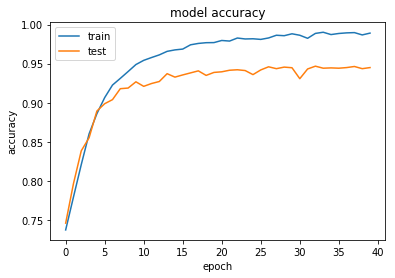

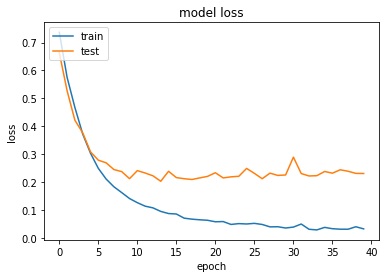

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()